![Fraud](./img/Fraud.png)
# Employment Scam Aegean Dataset
## 0. Imports and global settings

In [26]:
import scripts.plots as plots
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk import FreqDist, RegexpTokenizer, word_tokenize
import pandas as pd
import re
import seaborn as sns
import string
import warnings
from wordcloud import WordCloud

sns.set(palette='RdYlGn', context='talk', rc={'figure.figsize':(15,15)})
warnings.filterwarnings('ignore')
%reload_ext autoreload
%autoreload 2

## 0.1 Creating dataframes

In [27]:
df = pd.read_csv("./data/fake_job_postings.csv", index_col='job_id')
df.columns = df.columns.str.title()

In [28]:
dflegit = df[df['Fraudulent']==0]
dffraud = df[df['Fraudulent']==1]

In [29]:
df.sample(n=50)

Title  \
job_id                                                      
1098                         Digital Marketing Specialist   
3762                   Part Time Creative Project Manager   
3591                                      Quality Manager   
12173    Firmware Engineer - C# Visual Basic ASM SQL - FL   
11361   DH7 Business Admin Apprenticeship Under NAS 16...   
14345                         Senior Interaction Designer   
10258                                    Database Analyst   
15419                                  Software Developer   
14892                    Sales Development Representative   
13392                           Human Resources Assistant   
2212                                     Editorial Intern   
13227   Fulltime opening for Jr Software Developer Ope...   
3633                                    Design Draftsman    
15258                     Home Health CNA-Idaho Falls, ID   
11105                   Director, Supply Chain - Strategy   
6858    Business Development Manager - Banking & Inves...   
11205                                   Senior Python Dev   
14326                     Veterinary Assistant- Part-time   
13187                                       VP Operations   
78                   Mid-Senior .NET or Xamarin Developer   
14629                                Solutions Consultant   
15911                              Sales Proposal Manager   
10225                        Customer Service Associate     
13323                       Medical Receptionist - Casual   
12355   Entry Level Sales and Marketing Rep - Grand Ra...   
5288                           Customer Service Team Lead   
6954                        Dealer Service Representative   
1816    Paid Training for Direct Sales Representative ...   
6930                              Solution Architect-Crew   
5212    Solution Design Specialist and Content Develop...   
17037                            Senior Technical Manager   
9762     Head of Talent & Recruiting (remote/telecommute)   
16965                       Sales and Management Training   
4776       Senior IT Security Analyst - Threat Management   
13545   Business Development Specialist, Enterprise Sa...   
9745                    Account Executive (New York City)   
9524                        Sales and Marketing Assistant   
2336                                        Sales Manager   
1570       Market Segment Sales Manager - Industrial/OEM    
7443                     Software Developer (Java or PHP)   
8365                                     Testing Engineer   
4492                                   Sr. Java Developer   
11606                          Senior PHP Developer (m/f)   
4777                               Polish operations reps   
11868                                      Sales Engineer   
15202           People operations (HR)/Internal recruiter   
4384                                 Operations Principal   
14451                                        Patent Agent   
12376                    Customer Service Representative    
1537                                     Sales Consultant   

                        Location                     Department  \
job_id                                                            
1098               GR, I, Athens            Campaign Management   
3762           US, TN, Nashville                            NaN   
3591           US, OH, Cleveland                            NaN   
12173            US, FL, Daytona                            NaN   
11361      GB, DUR, Langley Moor                            NaN   
14345            GB, LND, London                          Tech    
10258              US, IN, 46802                            NaN   
15419            DE, BY, München                           tech   
14892             BE, VOV, Ghent                          Sales   
13392            GB, LND, London                            NaN   
2212                         NaN                      Editorial   
13227   

## 1. Missing values
Let's have a look at the data and see if there are any missing values.

In [30]:
_nalegit = pd.DataFrame(index=['Legit_HasValue','Legit_IsNA'])
_nafraud = pd.DataFrame(index=['Fraud_HasValue', 'Fraud_IsNA'])
for header in dflegit.columns:
    _nalegit[header] = dflegit[header].isna().value_counts()[0]
_nalegit.loc['Legit_IsNA'] = 17014 - _nalegit.loc['Legit_HasValue']
for header in dffraud.columns:
    _nafraud[header] = dffraud[header].isna().value_counts()[0]
_nafraud.loc['Fraud_IsNA'] = 866 - _nafraud.loc['Fraud_HasValue']
_nalegit = (round(_nalegit/17014*100, 1)).T
_nafraud = (round(_nafraud/866*100,1)).T
_na = _nalegit.merge(_nafraud,how='inner',left_on=_nalegit.index, right_on=_nafraud.index)
_na = _na.set_index(_na['key_0']).drop(columns='key_0')
_na.index.names = ['Columns']
_na

Legit_HasValue  Legit_IsNA  Fraud_HasValue  Fraud_IsNA
Columns                                                                    
Title                         100.0         0.0           100.0         0.0
Location                       98.1         1.9            97.8         2.2
Department                     35.3        64.7            38.7        61.3
Salary_Range                   15.5        84.5            25.8        74.2
Company_Profile                84.0        16.0            32.2        67.8
Description                   100.0         0.0            99.9         0.1
Requirements                   85.1        14.9            82.2        17.8
Benefits                       59.8        40.2            58.0        42.0
Telecommuting                 100.0         0.0           100.0         0.0
Has_Company_Logo              100.0         0.0           100.0         0.0
Has_Questions                 100.0         0.0           100.0         0.0
Employment_Type                81.0        19.0            72.2        27.8
Required_Experience            61.1        38.9            49.8        50.2
Required_Education             55.0        45.0            47.9        52.1
Industry                       72.8        27.2            68.2        31.8
Function                       64.0        36.0            61.1        38.9
Fraudulent                    100.0         0.0           100.0         0.0

17014


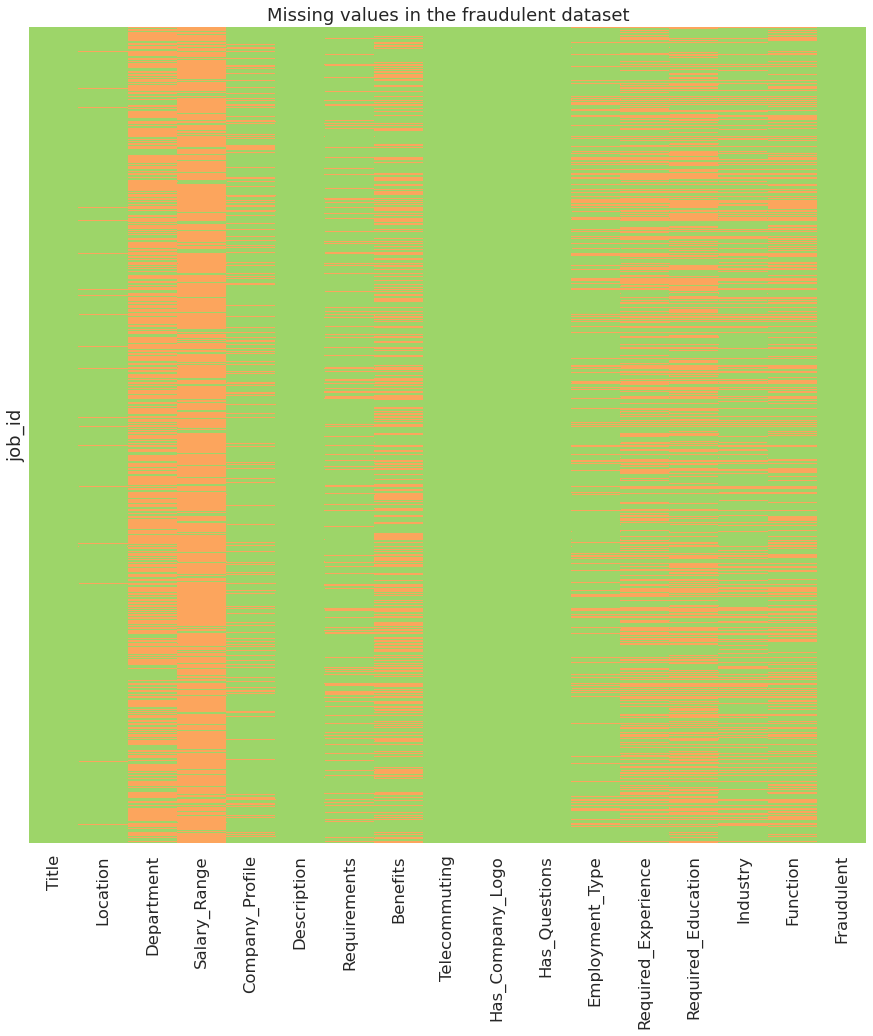

In [31]:
print(len(dflegit))
sns.heatmap(dflegit.isnull(), yticklabels=False, cbar=False, cmap=[sns.color_palette()[4],sns.color_palette()[1]]);
plt.title('Missing values in the fraudulent dataset');

866


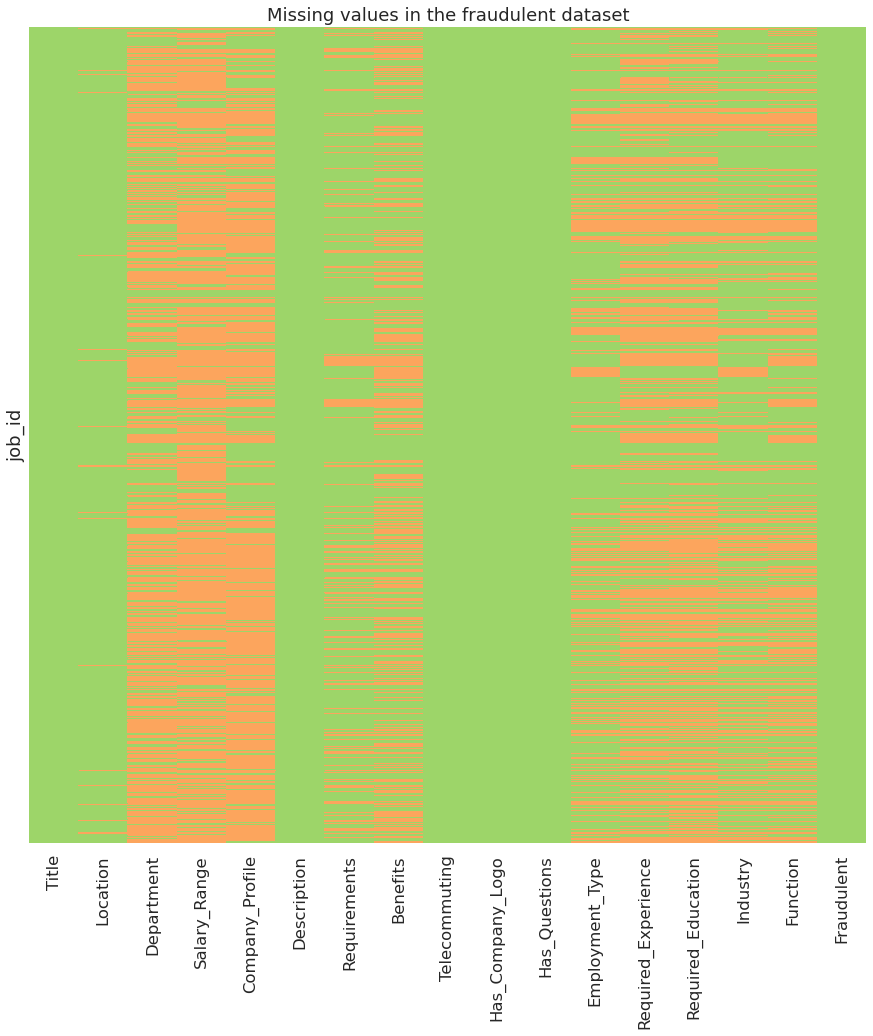

In [32]:
print(len(dffraud))
sns.heatmap(dffraud.isnull(), yticklabels=False, cbar=False, cmap=[sns.color_palette()[4],sns.color_palette()[1]]);
plt.title('Missing values in the fraudulent dataset');

## 1.1 Insight
This dataset contains 17880 jobs, with a maximum of 16 characteristics given to each job. On top of this information, all jobs entry have been assigned manually a "fraudulent" value of 1 (the post is fraudulent) or 0 (the post is legitimate); this resulted in 17014 job offers flagged as genuine whilst 866 were identified as fraudulent.

_Note: This assignment was done manually. Errors might have occurred._

The informations given for each job is separated in the following variables:

| Number | Title | Data type |
|---:|:---:| ---|
| 01 | title | text |
| 02 | location | text |
| 03 | department | text |
| 04 | salary_range | text |
| 05 | company_profile | text |
| 06 | description | text |
| 07 | requirements | text |
| 08 | benefits | text |
| 09 | telecommuting | binary |
| 10 | has_company_logo | binary |
| 11 | has_questions | binary |
| 12 | employment_type | categorical |
| 13 | required_experience | categorical |
| 14 | required_education | categorical |
| 15 | industry | categorical |
| 16 | function | categorical |
| 17 | fraudulent | binary |

There tend to be some repetitions in some fields; `company_profile` is an obvious one but, `description` can be very similar in some cases. These repetitions might affect tf-idf scores and might require a more in-depth analysis.

As the missing table shows, fraudulent posts tend to have more missing values than legitimate job posts, especially when it comes down to company profile. However, they seem to be rather keen on giving information about the salary range. Only one job doesn't have a job description (`df[df['description'].isna()==True]`); it is a fraudulent post for a position as an Office Manager in Warsaw, PL.

## 2. Text fields
From the missing value visualisation, we can see the fraudsters are struggling with the company profiles, etc. Let's look at text fields, in general, to see how creative the fraudsters are.
### 2.1 Trimming the text
There is some textual artefact that ned to be removed in order to have a more efficient word analysis.

In the following code,
- The first line will put a space before every capital letter (to avoid a wo.Rd scenario).
- The second line will remove the anonymised contact information.
- The third line will remove non-word characters, including digits.
- The fourth line will remove words shorter than three characters.
- The fifth line will convert multiple spaces into one space only.

In [33]:
for column in df.columns[4:8]:
    df[column].replace('([A-Z][a-z]|[A-Z] )', r' \1', regex=True, inplace=True)
    df[column].replace('(#URL\w+|#PHONE\w+|#EMAIL\w+)', ' ', regex=True, inplace=True)
    df[column].replace('(\\W|\\d)', ' ', regex=True, inplace=True)
    df[column].replace(r'\b\w{1,3}\b', ' ', regex=True, inplace=True)
    df[column].replace('\ +', ' ', regex=True, inplace=True)

### 2.2 Word Count
Next step is to look at how long posts are and, more specifically, if any difference between fraudulent posts and genuine ones exists.

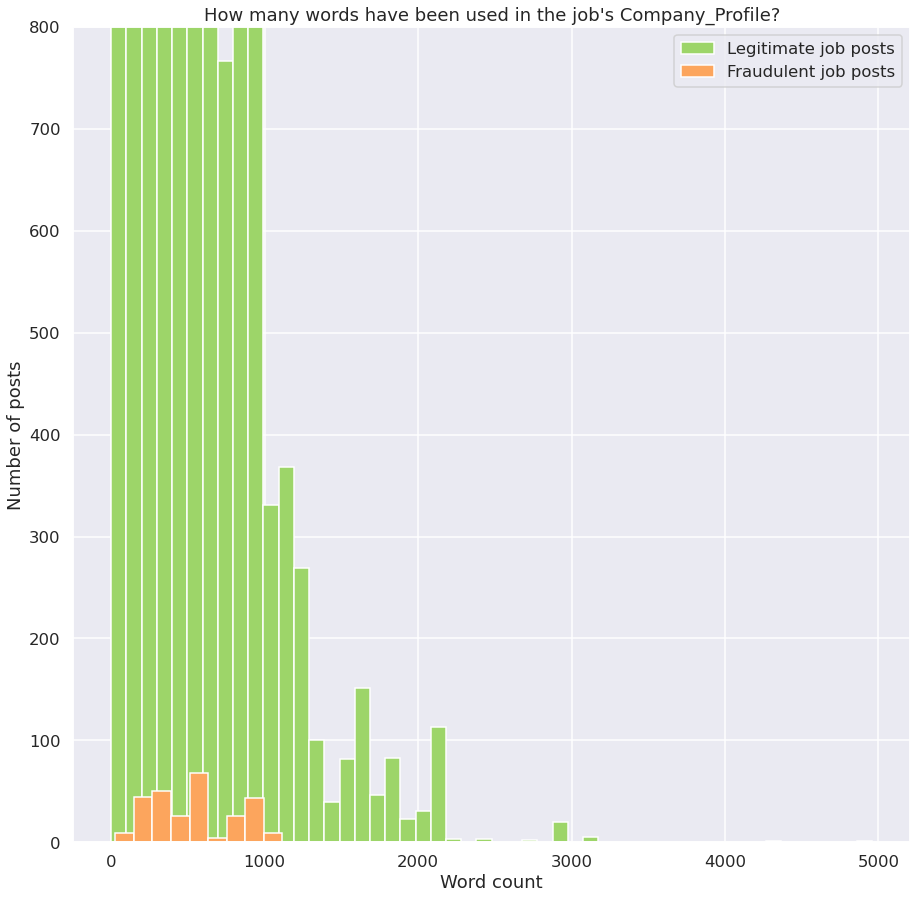

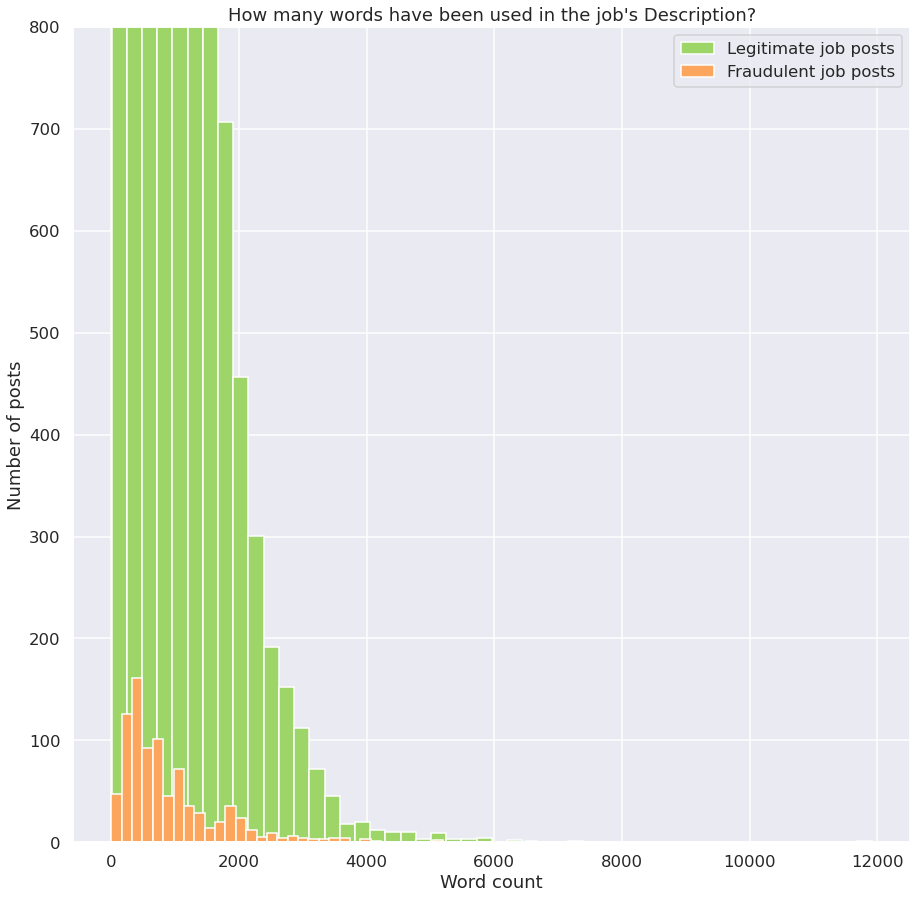

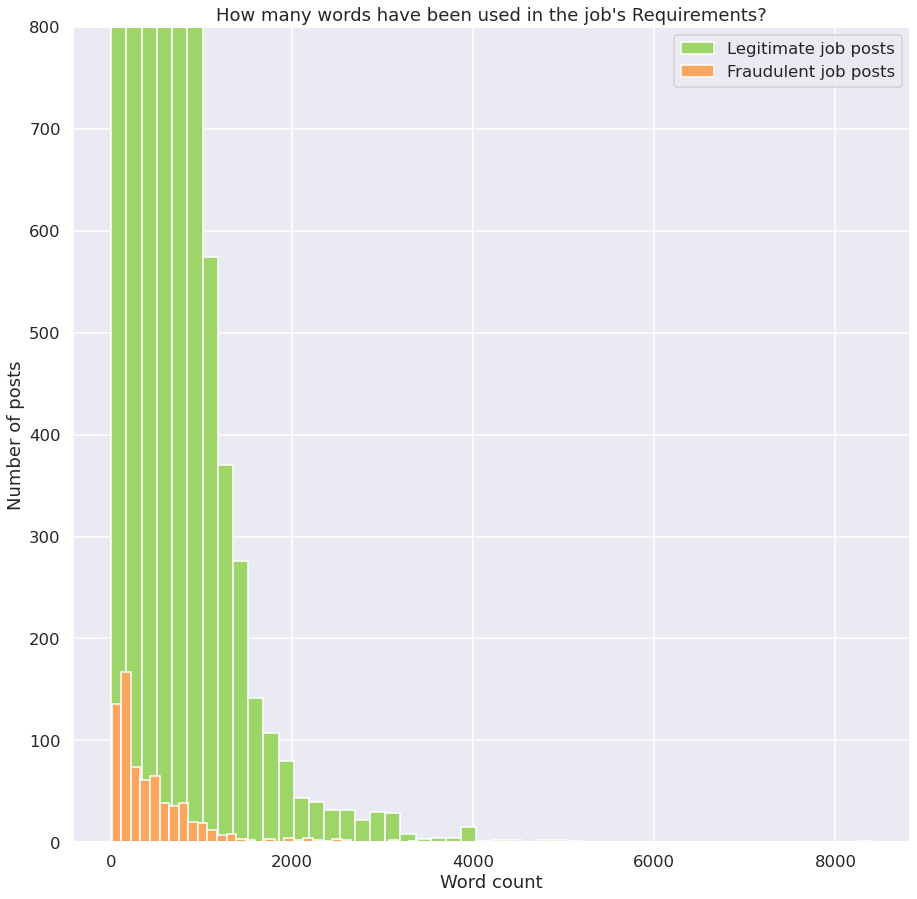

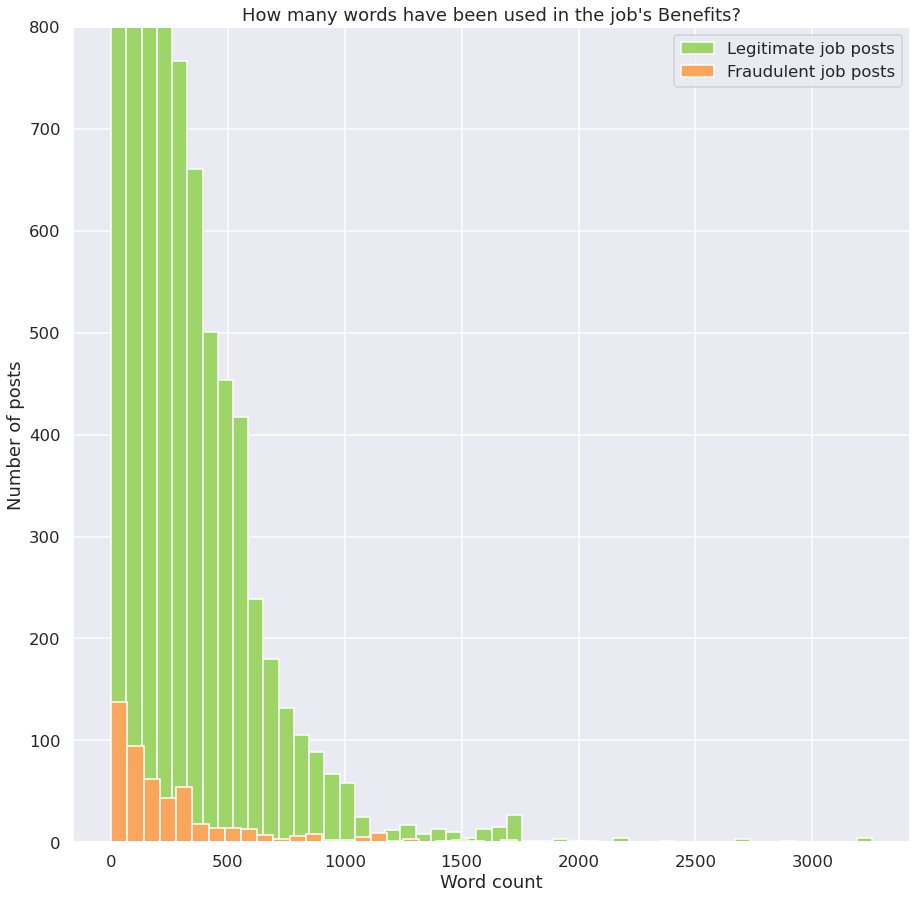

In [34]:
plots.Plots.word_dist_plot(df,4,8)

Not only are fraudulent job posts less complete than legitimate ones but, even when there is information, the fraudulent job posts are less loquacious than genuine job posts. This is especially true for job requirements and company_profile.

Let's have a more detailed look at the content itself.
### 2.3 Vocabulary Analysis
#### 2.3.1 Company Profile

In [35]:
# Removing stopwords
stop_words = list(string.punctuation)
stop_words += stopwords.words('english')
stop_words += [i for i in 'qwertyuioplkjhgfdsazxcvbnm0']

In [36]:
tokens = []
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

for profile in df['Company_Profile']:
    if isinstance(profile, str):
        tokenized_profile = tokenizer.tokenize(profile)
        for word in tokenized_profile:
            tokens.append(word.lower())
    else:
        tokens.append('0')

tokens_cp = [word for word in tokens if word not in stop_words]

In [37]:
vocab = {}
for i in tokens_cp:
    vocab[i] = vocab.get(i, 0) + 1

for i, t in enumerate(sorted(vocab.items(), key=lambda x:x[1], reverse=True), start=1):
    print(i, t)

1 ('team', 7493)
2 ('work', 7102)
3 ('company', 7091)
4 ('services', 6789)
5 ('people', 6593)
6 ('solutions', 5728)
7 ('business', 5607)
8 ('world', 4887)
9 ('clients', 4712)
10 ('technology', 4614)
11 ('companies', 4377)
12 ('help', 4338)
13 ('time', 3696)
14 ('management', 3265)
15 ('provide', 3241)
16 ('working', 3147)
17 ('service', 3142)
18 ('customer', 3071)
19 ('experience', 3059)
20 ('great', 2942)
21 ('best', 2909)
22 ('industry', 2881)
23 ('employees', 2858)
24 ('digital', 2788)
25 ('quality', 2685)
26 ('customers', 2652)
27 ('global', 2647)
28 ('based', 2598)
29 ('want', 2539)
30 ('like', 2527)
31 ('products', 2479)
32 ('full', 2435)
33 ('also', 2415)
34 ('every', 2394)
35 ('high', 2374)
36 ('right', 2371)
37 ('development', 2320)
38 ('years', 2278)
39 ('recruitment', 2266)
40 ('growing', 2249)
41 ('looking', 2221)
42 ('around', 2187)
43 ('process', 2179)
44 ('software', 2177)
45 ('well', 2154)
46 ('mobile', 2141)
47 ('mission', 2132)
48 ('innovative', 2095)
49 ('drive', 207

1699 ('finishing', 98)
1700 ('resistance', 98)
1701 ('setbacks', 98)
1702 ('judgement', 98)
1703 ('demonstrates', 98)
1704 ('reverence', 98)
1705 ('equality', 98)
1706 ('praise', 98)
1707 ('superiors', 98)
1708 ('workings', 98)
1709 ('note', 98)
1710 ('modernise', 98)
1711 ('intuitive', 98)
1712 ('dealer', 98)
1713 ('shyp', 98)
1714 ('friend', 97)
1715 ('promises', 97)
1716 ('profitability', 97)
1717 ('second', 97)
1718 ('connects', 97)
1719 ('additional', 97)
1720 ('responsibility', 97)
1721 ('incredible', 97)
1722 ('code', 97)
1723 ('definitely', 97)
1724 ('amsterdam', 97)
1725 ('fans', 97)
1726 ('lane', 97)
1727 ('explore', 96)
1728 ('precision', 96)
1729 ('vehicles', 96)
1730 ('ramberg', 96)
1731 ('screened', 96)
1732 ('vacancies', 96)
1733 ('reports', 96)
1734 ('payment', 96)
1735 ('scheme', 96)
1736 ('breaks', 96)
1737 ('humour', 96)
1738 ('earn', 95)
1739 ('spend', 95)
1740 ('profitable', 95)
1741 ('licensed', 95)
1742 ('loyalty', 95)
1743 ('either', 95)
1744 ('awarded', 95)
174

2705 ('calidad', 49)
2706 ('southwestern', 49)
2707 ('permeate', 49)
2708 ('simplest', 49)
2709 ('words', 49)
2710 ('tomorrow', 49)
2711 ('enjoyable', 49)
2712 ('conventional', 49)
2713 ('layar', 49)
2714 ('chart', 49)
2715 ('involvement', 49)
2716 ('localization', 49)
2717 ('cisco', 49)
2718 ('worker', 49)
2719 ('rated', 48)
2720 ('tokyo', 48)
2721 ('turnkey', 48)
2722 ('patent', 48)
2723 ('views', 48)
2724 ('ruby', 48)
2725 ('talking', 48)
2726 ('simplicity', 48)
2727 ('popular', 48)
2728 ('mentoring', 48)
2729 ('regardless', 48)
2730 ('components', 48)
2731 ('recruited', 48)
2732 ('director', 48)
2733 ('tens', 48)
2734 ('cultures', 48)
2735 ('depend', 48)
2736 ('shoreditch', 48)
2737 ('simplified', 48)
2738 ('columbia', 48)
2739 ('interim', 48)
2740 ('possibly', 48)
2741 ('contemporary', 48)
2742 ('pathway', 48)
2743 ('photos', 48)
2744 ('occasions', 48)
2745 ('recombine', 48)
2746 ('promotes', 48)
2747 ('devoted', 48)
2748 ('taken', 48)
2749 ('ride', 48)
2750 ('recover', 48)
2751 (

4240 ('ordinary', 23)
4241 ('calls', 23)
4242 ('vista', 23)
4243 ('instant', 23)
4244 ('enthusiasts', 22)
4245 ('consist', 22)
4246 ('charge', 22)
4247 ('teknique', 22)
4248 ('upgrade', 22)
4249 ('characterized', 22)
4250 ('specialises', 22)
4251 ('traded', 22)
4252 ('judge', 22)
4253 ('edit', 22)
4254 ('ashley', 22)
4255 ('gallery', 22)
4256 ('granted', 22)
4257 ('acquire', 22)
4258 ('simplifying', 22)
4259 ('hugely', 22)
4260 ('frameworks', 22)
4261 ('prides', 22)
4262 ('mathematicians', 22)
4263 ('relentlessly', 22)
4264 ('leisure', 22)
4265 ('afraid', 22)
4266 ('insist', 22)
4267 ('preventive', 22)
4268 ('remotely', 22)
4269 ('questioning', 22)
4270 ('firmly', 22)
4271 ('despise', 22)
4272 ('entitlement', 22)
4273 ('duct', 22)
4274 ('tape', 22)
4275 ('baling', 22)
4276 ('complain', 22)
4277 ('midwestern', 22)
4278 ('fostered', 22)
4279 ('avoided', 22)
4280 ('thursdays', 22)
4281 ('shrinking', 22)
4282 ('violets', 22)
4283 ('agronomist', 22)
4284 ('physicist', 22)
4285 ('scientist',

5650 ('starwood', 12)
5651 ('expertly', 12)
5652 ('continuum', 12)
5653 ('deliverables', 12)
5654 ('frequency', 12)
5655 ('franchised', 12)
5656 ('circle', 12)
5657 ('authorised', 12)
5658 ('downloads', 12)
5659 ('todo', 12)
5660 ('integrales', 12)
5661 ('adem', 12)
5662 ('trafficked', 12)
5663 ('eric', 12)
5664 ('schmidt', 12)
5665 ('retrofit', 12)
5666 ('province', 12)
5667 ('cloudreach', 12)
5668 ('campaigners', 12)
5669 ('handles', 12)
5670 ('explains', 12)
5671 ('scypho', 12)
5672 ('temperature', 12)
5673 ('lafayette', 12)
5674 ('mille', 12)
5675 ('enterpris', 12)
5676 ('softwar', 12)
5677 ('smar', 12)
5678 ('staked', 12)
5679 ('elude', 12)
5680 ('worthless', 12)
5681 ('morocco', 12)
5682 ('nepal', 12)
5683 ('vietnam', 12)
5684 ('lawyers', 12)
5685 ('prospective', 12)
5686 ('exit', 12)
5687 ('incessantly', 12)
5688 ('mondays', 12)
5689 ('wednesdays', 12)
5690 ('woven', 12)
5691 ('inaugural', 12)
5692 ('grea', 12)
5693 ('swif', 12)
5694 ('innotribe', 12)
5695 ('stacked', 12)
5696 (

7200 ('tides', 7)
7201 ('waves', 7)
7202 ('amazoners', 7)
7203 ('innoavtive', 7)
7204 ('pyramid', 7)
7205 ('humanly', 7)
7206 ('albert', 7)
7207 ('einstein', 7)
7208 ('alan', 7)
7209 ('oprah', 7)
7210 ('winfrey', 7)
7211 ('manila', 7)
7212 ('monetizing', 7)
7213 ('reduces', 7)
7214 ('chair', 7)
7215 ('weekends', 7)
7216 ('middlemen', 7)
7217 ('opaque', 7)
7218 ('followers', 7)
7219 ('beliefs', 7)
7220 ('informational', 7)
7221 ('allentown', 7)
7222 ('aggregations', 7)
7223 ('summarization', 7)
7224 ('typing', 7)
7225 ('fleksy', 7)
7226 ('interiors', 7)
7227 ('elate', 7)
7228 ('needsl', 7)
7229 ('industriesli', 7)
7230 ('virgin', 7)
7231 ('visible', 7)
7232 ('cheveux', 7)
7233 ('capitalized', 7)
7234 ('acquainted', 7)
7235 ('shortcomings', 7)
7236 ('detangle', 7)
7237 ('complications', 7)
7238 ('arise', 7)
7239 ('prevalent', 7)
7240 ('standardized', 7)
7241 ('signs', 7)
7242 ('sabre', 7)
7243 ('wheely', 7)
7244 ('mailcloud', 7)
7245 ('fullest', 7)
7246 ('ambiance', 7)
7247 ('brimming', 

8630 ('unemployment', 4)
8631 ('attempts', 4)
8632 ('converts', 4)
8633 ('heterogeneous', 4)
8634 ('correlated', 4)
8635 ('overhead', 4)
8636 ('abolish', 4)
8637 ('minted', 4)
8638 ('catalyze', 4)
8639 ('magnitude', 4)
8640 ('backwater', 4)
8641 ('ambit', 4)
8642 ('chops', 4)
8643 ('promptly', 4)
8644 ('inquires', 4)
8645 ('edward', 4)
8646 ('miller', 4)
8647 ('garage', 4)
8648 ('delighting', 4)
8649 ('netotiate', 4)
8650 ('todaymade', 4)
8651 ('avelgood', 4)
8652 ('bird', 4)
8653 ('pinpoint', 4)
8654 ('clipping', 4)
8655 ('appliance', 4)
8656 ('gulf', 4)
8657 ('pierce', 4)
8658 ('mattie', 4)
8659 ('crafts', 4)
8660 ('tenacity', 4)
8661 ('geotag', 4)
8662 ('aeroview', 4)
8663 ('punch', 4)
8664 ('outsized', 4)
8665 ('bewdd', 4)
8666 ('maria', 4)
8667 ('chef', 4)
8668 ('bedrosian', 4)
8669 ('xpitality', 4)
8670 ('parcel', 4)
8671 ('berkeley', 4)
8672 ('loftplan', 4)
8673 ('loft', 4)
8674 ('indicative', 4)
8675 ('korres', 4)
8676 ('homeopathic', 4)
8677 ('herbal', 4)
8678 ('microbiology',

9992 ('showcases', 2)
9993 ('shield', 2)
9994 ('reputed', 2)
9995 ('matchless', 2)
9996 ('pays', 2)
9997 ('navi', 2)
9998 ('deck', 2)
9999 ('cavalier', 2)
10000 ('possesses', 2)
10001 ('publicists', 2)
10002 ('cleantech', 2)
10003 ('dade', 2)
10004 ('broward', 2)
10005 ('interdependence', 2)
10006 ('arranged', 2)
10007 ('reviewing', 2)
10008 ('sailors', 2)
10009 ('maximizes', 2)
10010 ('inkly', 2)
10011 ('greetings', 2)
10012 ('pound', 2)
10013 ('superheroes', 2)
10014 ('enthusiam', 2)
10015 ('emphasizing', 2)
10016 ('bedford', 2)
10017 ('decisive', 2)
10018 ('matchmaking', 2)
10019 ('commerzbank', 2)
10020 ('avant', 2)
10021 ('garde', 2)
10022 ('guestlist', 2)
10023 ('speciality', 2)
10024 ('infant', 2)
10025 ('weapon', 2)
10026 ('democratise', 2)
10027 ('billboards', 2)
10028 ('uncertain', 2)
10029 ('ismoo', 2)
10030 ('ballparc', 2)
10031 ('insertions', 2)
10032 ('incremental', 2)
10033 ('smarttv', 2)
10034 ('xbox', 2)
10035 ('neot', 2)
10036 ('boxes', 2)
10037 ('tweakker', 2)
10038 

11535 ('takeaway', 1)
11536 ('colours', 1)
11537 ('fonts', 1)
11538 ('beautify', 1)
11539 ('hailed', 1)
11540 ('gigaom', 1)
11541 ('basically', 1)
11542 ('webjar', 1)
11543 ('preoccupation', 1)
11544 ('archiving', 1)
11545 ('encoding', 1)
11546 ('beginners', 1)
11547 ('forex', 1)
11548 ('butter', 1)
11549 ('drama', 1)
11550 ('assholes', 1)
11551 ('wyoming', 1)
11552 ('indvidual', 1)
11553 ('expereience', 1)
11554 ('screacht', 1)
11555 ('screachtv', 1)
11556 ('engages', 1)
11557 ('noise', 1)
11558 ('milaap', 1)
11559 ('favortie', 1)
11560 ('gaggleamp', 1)
11561 ('gaggletm', 1)
11562 ('amplification', 1)
11563 ('wasted', 1)
11564 ('migrations', 1)
11565 ('curamine', 1)
11566 ('redmine', 1)
11567 ('srinagar', 1)
11568 ('generalists', 1)
11569 ('themers', 1)
11570 ('incarnation', 1)
11571 ('mature', 1)
11572 ('xpress', 1)
11573 ('judicata', 1)
11574 ('twelve', 1)
11575 ('thiel', 1)
11576 ('khosla', 1)
11577 ('ontology', 1)
11578 ('dreamed', 1)
11579 ('unrivaled', 1)
11580 ('solutionse', 1)

#### 2.3.1.1 Company Profiles of Fraudulent Posts

In [38]:
tokens = []
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

for profile in dffraud['Company_Profile']:
    if isinstance(profile, str):
        tokenized_profile = tokenizer.tokenize(profile)
        for word in tokenized_profile:
            tokens.append(word.lower())
    else:
        tokens.append('0')

tokens_cp = [word for word in tokens if word not in stop_words]

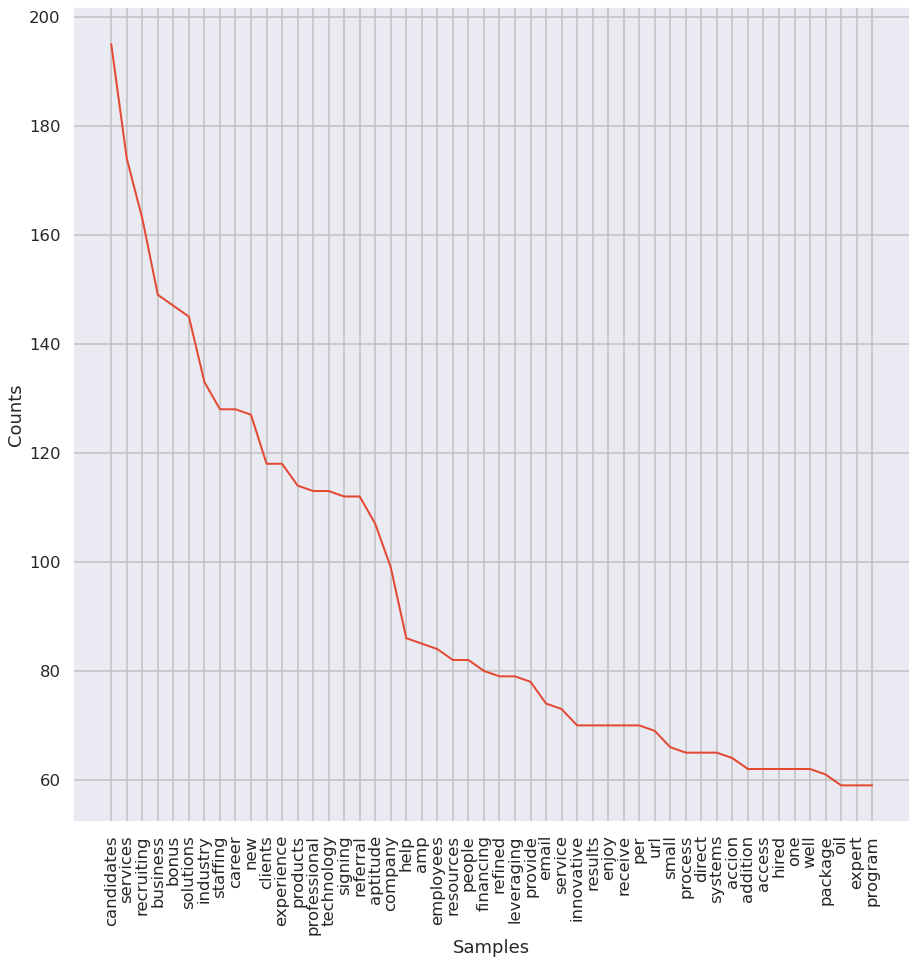

In [39]:
FreqDist(tokens_cp).plot(50)
plt.show()

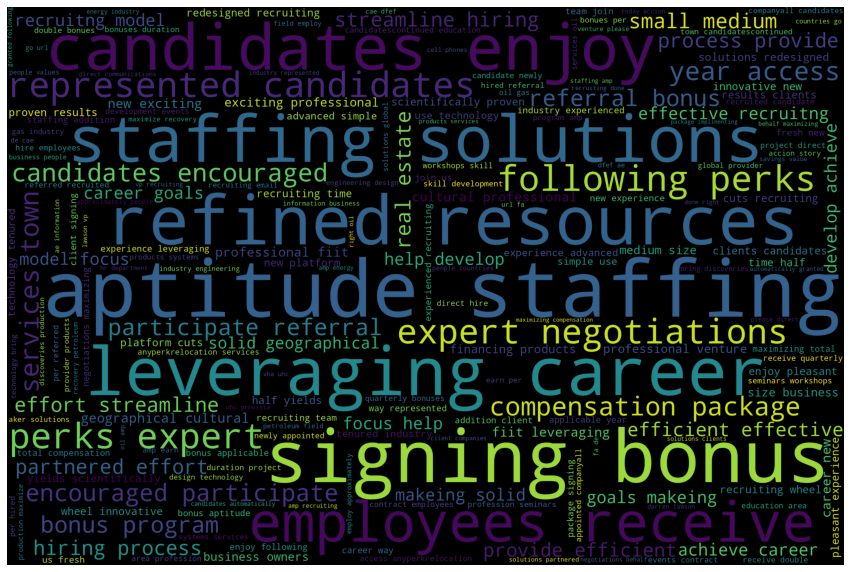

In [40]:
wordcloud = WordCloud(width = 3000,
                      height = 2000,
                      stopwords = stop_words)

wordcloud.generate(" ".join(tokens_cp))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### 2.3.1.2 Company Profile of Legitimate Posts

In [41]:
tokens = []
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

for profile in dflegit['Company_Profile']:
    if isinstance(profile, str):
        tokenized_profile = tokenizer.tokenize(profile)
        for word in tokenized_profile:
            tokens.append(word.lower())
    else:
        tokens.append('0')

tokens_cp = [word for word in tokens if word not in stop_words]

In [42]:
len(tokens_cp)
# 948364 for df
# 18771 for dffraud
# 1019554 for dflegit

1016833

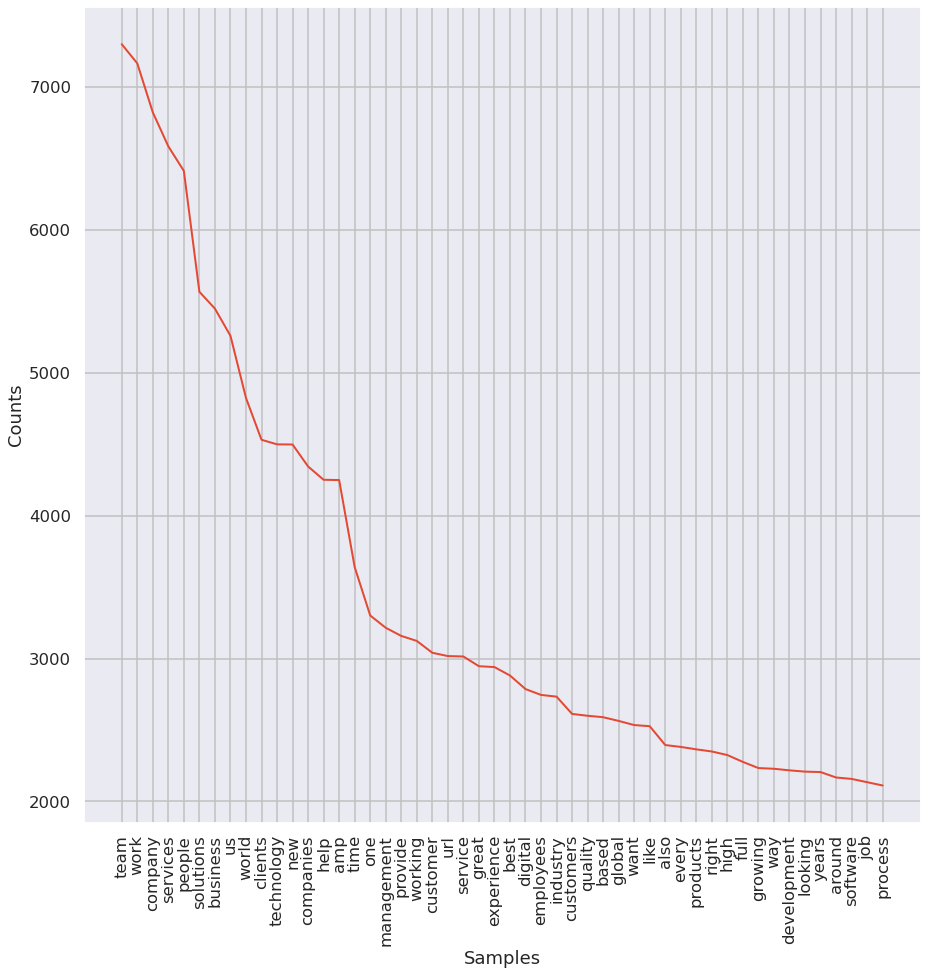

In [43]:
FreqDist(tokens_cp).plot(50)
plt.show()

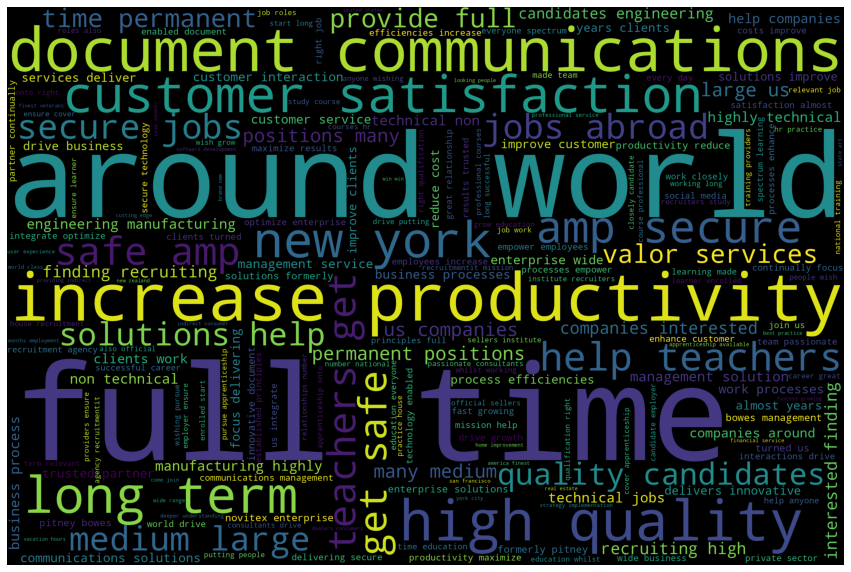

In [44]:
wordcloud = WordCloud(width = 3000,
                      height = 2000,
                      stopwords = stop_words)

wordcloud.generate(" ".join(tokens_cp))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Looking at the content of fraudulent ads, it appears, the company profile would be more individual focussed, with terms like candidates, recruiting, bonus, staffing, career, signing, referral, etc.

A legitimate company seem to be more mission focussed with terms like team, people, solutions, help, business, etc.

### 2.3.2 Description

In [45]:
tokens = []
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

for profile in df['Description']:
    if isinstance(profile, str):
        tokenized_profile = tokenizer.tokenize(profile)
        for word in tokenized_profile:
            tokens.append(word.lower())
    else:
        tokens.append('0')

tokens_cp = [word for word in tokens if word not in stop_words]

In [46]:
vocab = {}
for i in tokens_cp:
    vocab[i] = vocab.get(i, 0) + 1

for i, t in enumerate(sorted(vocab.items(), key=lambda x:x[1], reverse=True), start=1):
    print(i, t)

1 ('team', 19419)
2 ('work', 16605)
3 ('experience', 11708)
4 ('business', 11200)
5 ('company', 10534)
6 ('customer', 9967)
7 ('sales', 9659)
8 ('looking', 8792)
9 ('development', 8572)
10 ('management', 8340)
11 ('product', 7640)
12 ('service', 7430)
13 ('support', 7163)
14 ('marketing', 6991)
15 ('design', 6647)
16 ('time', 6594)
17 ('services', 6571)
18 ('working', 6339)
19 ('skills', 6309)
20 ('position', 6302)
21 ('client', 6281)
22 ('data', 6227)
23 ('customers', 6036)
24 ('clients', 5902)
25 ('role', 5781)
26 ('provide', 5717)
27 ('responsibilities', 5552)
28 ('ensure', 5223)
29 ('project', 5078)
30 ('based', 5010)
31 ('products', 4897)
32 ('including', 4865)
33 ('software', 4820)
34 ('help', 4814)
35 ('develop', 4742)
36 ('quality', 4718)
37 ('responsible', 4687)
38 ('manager', 4669)
39 ('high', 4586)
40 ('opportunity', 4478)
41 ('well', 4402)
42 ('people', 4398)
43 ('must', 4390)
44 ('environment', 4374)
45 ('solutions', 4285)
46 ('maintain', 4270)
47 ('required', 4264)
48 ('p

1385 ('interactions', 253)
1386 ('resolving', 253)
1387 ('advantage', 253)
1388 ('music', 253)
1389 ('instructional', 253)
1390 ('rules', 252)
1391 ('conversion', 252)
1392 ('beach', 252)
1393 ('teaching', 252)
1394 ('hear', 251)
1395 ('editorial', 251)
1396 ('enhancements', 251)
1397 ('vehicle', 251)
1398 ('step', 251)
1399 ('graphic', 251)
1400 ('firms', 250)
1401 ('defining', 250)
1402 ('proficient', 250)
1403 ('repairs', 250)
1404 ('queries', 249)
1405 ('duration', 249)
1406 ('engine', 248)
1407 ('collections', 248)
1408 ('conferences', 248)
1409 ('similar', 247)
1410 ('contractors', 247)
1411 ('temporary', 247)
1412 ('emerging', 247)
1413 ('lines', 246)
1414 ('certification', 246)
1415 ('schools', 246)
1416 ('communities', 246)
1417 ('gathering', 245)
1418 ('compelling', 245)
1419 ('points', 245)
1420 ('margin', 245)
1421 ('articulate', 244)
1422 ('star', 244)
1423 ('risks', 244)
1424 ('sets', 244)
1425 ('seeks', 243)
1426 ('qubit', 243)
1427 ('bringing', 242)
1428 ('familiarity',

2839 ('left', 86)
2840 ('photography', 86)
2841 ('scratch', 86)
2842 ('impactful', 86)
2843 ('interpreting', 86)
2844 ('propose', 86)
2845 ('exceptionally', 86)
2846 ('redis', 86)
2847 ('ethical', 86)
2848 ('scientific', 86)
2849 ('kinds', 86)
2850 ('promptly', 86)
2851 ('calendars', 86)
2852 ('fixing', 86)
2853 ('impressive', 86)
2854 ('therapist', 86)
2855 ('crew', 86)
2856 ('doctors', 85)
2857 ('hadoop', 85)
2858 ('namely', 85)
2859 ('streams', 85)
2860 ('strategists', 85)
2861 ('correcting', 85)
2862 ('apartment', 85)
2863 ('acts', 85)
2864 ('incidents', 85)
2865 ('brussels', 85)
2866 ('survey', 85)
2867 ('cooking', 85)
2868 ('evolution', 85)
2869 ('architectures', 85)
2870 ('enhancing', 85)
2871 ('errands', 85)
2872 ('multidisciplinary', 85)
2873 ('customized', 85)
2874 ('carefully', 84)
2875 ('contractual', 84)
2876 ('authentic', 84)
2877 ('enterprises', 84)
2878 ('thriving', 84)
2879 ('frames', 84)
2880 ('installing', 84)
2881 ('savings', 84)
2882 ('programmatic', 84)
2883 ('beg

4278 ('steady', 42)
4279 ('participatory', 42)
4280 ('taxes', 42)
4281 ('stripe', 42)
4282 ('brochures', 42)
4283 ('heat', 42)
4284 ('fail', 42)
4285 ('benchmarking', 42)
4286 ('wholesale', 42)
4287 ('occasions', 42)
4288 ('deloitte', 42)
4289 ('contents', 42)
4290 ('leaving', 42)
4291 ('eagerness', 42)
4292 ('spain', 42)
4293 ('reasons', 42)
4294 ('auditors', 42)
4295 ('uncapped', 42)
4296 ('certificate', 42)
4297 ('exactly', 42)
4298 ('aligns', 42)
4299 ('sustainability', 42)
4300 ('individually', 42)
4301 ('church', 42)
4302 ('acceptin', 42)
4303 ('donor', 42)
4304 ('finally', 42)
4305 ('upsilon', 42)
4306 ('counties', 42)
4307 ('tokyo', 41)
4308 ('quarter', 41)
4309 ('envision', 41)
4310 ('cannot', 41)
4311 ('mentors', 41)
4312 ('automating', 41)
4313 ('label', 41)
4314 ('facets', 41)
4315 ('extraction', 41)
4316 ('lucrative', 41)
4317 ('credentials', 41)
4318 ('courtesy', 41)
4319 ('rotating', 41)
4320 ('enforcement', 41)
4321 ('mails', 41)
4322 ('showcase', 41)
4323 ('finances', 

6099 ('arabic', 21)
6100 ('photovoltaic', 21)
6101 ('comprehensiveness', 21)
6102 ('newscasts', 21)
6103 ('mitigating', 21)
6104 ('homeowner', 21)
6105 ('musicians', 21)
6106 ('potentials', 21)
6107 ('gust', 21)
6108 ('opens', 21)
6109 ('dozen', 21)
6110 ('meatball', 21)
6111 ('prioritized', 21)
6112 ('dinner', 21)
6113 ('booming', 21)
6114 ('typist', 21)
6115 ('happening', 21)
6116 ('colleges', 21)
6117 ('illustration', 21)
6118 ('shit', 21)
6119 ('mondays', 21)
6120 ('onshore', 21)
6121 ('forget', 21)
6122 ('zoek', 21)
6123 ('zich', 21)
6124 ('proccess', 21)
6125 ('coppy', 21)
6126 ('adrian', 21)
6127 ('convenient', 21)
6128 ('bound', 21)
6129 ('restless', 21)
6130 ('societies', 21)
6131 ('malfunctions', 21)
6132 ('court', 21)
6133 ('league', 21)
6134 ('agricultural', 21)
6135 ('edinburgh', 21)
6136 ('restore', 21)
6137 ('devs', 21)
6138 ('iteratively', 21)
6139 ('creators', 21)
6140 ('elle', 21)
6141 ('centred', 21)
6142 ('vascular', 21)
6143 ('nieuwe', 21)
6144 ('landmark', 21)
614

7560 ('mumbai', 13)
7561 ('announce', 13)
7562 ('twilio', 13)
7563 ('relief', 13)
7564 ('xbox', 13)
7565 ('beds', 13)
7566 ('moscow', 13)
7567 ('requisition', 13)
7568 ('newspaper', 13)
7569 ('formerly', 13)
7570 ('distilling', 13)
7571 ('delinquency', 13)
7572 ('foreclosure', 13)
7573 ('hazwope', 13)
7574 ('exploratory', 13)
7575 ('reuters', 13)
7576 ('cookie', 13)
7577 ('inefficiencies', 13)
7578 ('constituents', 13)
7579 ('reusability', 13)
7580 ('reimbursements', 13)
7581 ('dube', 13)
7582 ('extrusion', 13)
7583 ('licence', 13)
7584 ('hole', 13)
7585 ('untapped', 13)
7586 ('mailroom', 13)
7587 ('corpus', 13)
7588 ('christi', 13)
7589 ('averaging', 13)
7590 ('imaginative', 13)
7591 ('proportions', 13)
7592 ('artful', 13)
7593 ('existence', 13)
7594 ('presently', 13)
7595 ('instincts', 13)
7596 ('ensight', 13)
7597 ('experimental', 13)
7598 ('fiction', 13)
7599 ('equifax', 13)
7600 ('cohort', 13)
7601 ('gauging', 13)
7602 ('checked', 13)
7603 ('morgan', 13)
7604 ('differentiators', 1

8961 ('lends', 9)
8962 ('goldstar', 9)
8963 ('pasadena', 9)
8964 ('solicits', 9)
8965 ('repo', 9)
8966 ('yesterday', 9)
8967 ('principally', 9)
8968 ('derived', 9)
8969 ('geeft', 9)
8970 ('leiding', 9)
8971 ('werkt', 9)
8972 ('inappropriate', 9)
8973 ('administratively', 9)
8974 ('didactics', 9)
8975 ('mistake', 9)
8976 ('granted', 9)
8977 ('browse', 9)
8978 ('liase', 9)
8979 ('pristine', 9)
8980 ('oldest', 9)
8981 ('grad', 9)
8982 ('thursdays', 9)
8983 ('registry', 9)
8984 ('nationality', 9)
8985 ('suspensions', 9)
8986 ('waynesburg', 9)
8987 ('buckhannon', 9)
8988 ('oilfield', 9)
8989 ('seal', 9)
8990 ('endorsement', 9)
8991 ('simpler', 9)
8992 ('trays', 9)
8993 ('tesco', 9)
8994 ('riga', 9)
8995 ('nationalities', 9)
8996 ('trak', 9)
8997 ('scrub', 9)
8998 ('sanitize', 9)
8999 ('glendale', 9)
9000 ('predicting', 9)
9001 ('hayward', 9)
9002 ('escort', 9)
9003 ('itemized', 9)
9004 ('articulation', 9)
9005 ('unwanted', 9)
9006 ('impacted', 9)
9007 ('microfinance', 9)
9008 ('haml', 9)
90

10318 ('passwords', 6)
10319 ('hooks', 6)
10320 ('propensity', 6)
10321 ('paving', 6)
10322 ('shoul', 6)
10323 ('executable', 6)
10324 ('antique', 6)
10325 ('petting', 6)
10326 ('ubiquitously', 6)
10327 ('indoctrinate', 6)
10328 ('exploitation', 6)
10329 ('valor', 6)
10330 ('respectively', 6)
10331 ('developmen', 6)
10332 ('zell', 6)
10333 ('pods', 6)
10334 ('cathlon', 6)
10335 ('storesupport', 6)
10336 ('telematics', 6)
10337 ('exploit', 6)
10338 ('enforced', 6)
10339 ('damn', 6)
10340 ('refined', 6)
10341 ('faceobsess', 6)
10342 ('producesweat', 6)
10343 ('sobe', 6)
10344 ('obsessing', 6)
10345 ('timed', 6)
10346 ('rebate', 6)
10347 ('william', 6)
10348 ('medtronic', 6)
10349 ('chairman', 6)
10350 ('fishers', 6)
10351 ('techpoint', 6)
10352 ('discerning', 6)
10353 ('collector', 6)
10354 ('erosion', 6)
10355 ('sediment', 6)
10356 ('entitlements', 6)
10357 ('populate', 6)
10358 ('inefficient', 6)
10359 ('rockstars', 6)
10360 ('occupants', 6)
10361 ('attaching', 6)
10362 ('manifest', 6)

11750 ('permanen', 5)
11751 ('intensely', 5)
11752 ('pollfish', 5)
11753 ('bayesian', 5)
11754 ('hirin', 5)
11755 ('notting', 5)
11756 ('rabbitm', 5)
11757 ('linu', 5)
11758 ('vomit', 5)
11759 ('cans', 5)
11760 ('hacks', 5)
11761 ('cells', 5)
11762 ('revolutionised', 5)
11763 ('featuring', 5)
11764 ('produc', 5)
11765 ('handyman', 5)
11766 ('equa', 5)
11767 ('tno', 5)
11768 ('vile', 5)
11769 ('mandarin', 5)
11770 ('capitalised', 5)
11771 ('whimsical', 5)
11772 ('ports', 5)
11773 ('cactus', 5)
11774 ('belongings', 5)
11775 ('gave', 5)
11776 ('novatio', 5)
11777 ('transformer', 5)
11778 ('preparatory', 5)
11779 ('logbook', 5)
11780 ('groundwork', 5)
11781 ('mate', 5)
11782 ('polyglot', 5)
11783 ('emotionally', 5)
11784 ('chips', 5)
11785 ('individuality', 5)
11786 ('postal', 5)
11787 ('reactivation', 5)
11788 ('effortless', 5)
11789 ('ambulance', 5)
11790 ('importation', 5)
11791 ('megaventory', 5)
11792 ('translational', 5)
11793 ('boarded', 5)
11794 ('rabbit', 5)
11795 ('scorecard', 5)

13000 ('settling', 4)
13001 ('bengaluru', 4)
13002 ('tickle', 4)
13003 ('wroc', 4)
13004 ('webex', 4)
13005 ('greeter', 4)
13006 ('jado', 4)
13007 ('pado', 4)
13008 ('impending', 4)
13009 ('intranets', 4)
13010 ('sodastream', 4)
13011 ('invaders', 4)
13012 ('specialisms', 4)
13013 ('bounce', 4)
13014 ('thin', 4)
13015 ('otak', 4)
13016 ('laughing', 4)
13017 ('bistro', 4)
13018 ('addicted', 4)
13019 ('bookstores', 4)
13020 ('appdev', 4)
13021 ('organiser', 4)
13022 ('documentum', 4)
13023 ('incarnation', 4)
13024 ('millionaires', 4)
13025 ('synergy', 4)
13026 ('demiurge', 4)
13027 ('discharges', 4)
13028 ('georgetown', 4)
13029 ('sind', 4)
13030 ('elbow', 4)
13031 ('birdback', 4)
13032 ('roadway', 4)
13033 ('parametric', 4)
13034 ('pants', 4)
13035 ('slicks', 4)
13036 ('interana', 4)
13037 ('aptitudes', 4)
13038 ('estat', 4)
13039 ('wright', 4)
13040 ('therapies', 4)
13041 ('evidenced', 4)
13042 ('recs', 4)
13043 ('addictions', 4)
13044 ('hoist', 4)
13045 ('reflecting', 4)
13046 ('sunse

14629 ('ford', 3)
14630 ('bribespot', 3)
14631 ('bribe', 3)
14632 ('behold', 3)
14633 ('wizardry', 3)
14634 ('trustworthiness', 3)
14635 ('blurred', 3)
14636 ('astronomy', 3)
14637 ('plane', 3)
14638 ('investigated', 3)
14639 ('locksmith', 3)
14640 ('aldgate', 3)
14641 ('procurements', 3)
14642 ('synced', 3)
14643 ('robo', 3)
14644 ('dalet', 3)
14645 ('hospitalized', 3)
14646 ('emaginal', 3)
14647 ('broadening', 3)
14648 ('infiniband', 3)
14649 ('blazing', 3)
14650 ('trails', 3)
14651 ('saleso', 3)
14652 ('helmets', 3)
14653 ('respirators', 3)
14654 ('correlates', 3)
14655 ('bootcamps', 3)
14656 ('gantt', 3)
14657 ('iptables', 3)
14658 ('namespaces', 3)
14659 ('notions', 3)
14660 ('bonsey', 3)
14661 ('jaden', 3)
14662 ('affective', 3)
14663 ('disseminating', 3)
14664 ('chipset', 3)
14665 ('drawn', 3)
14666 ('amigos', 3)
14667 ('theoverall', 3)
14668 ('splunk', 3)
14669 ('reimbursable', 3)
14670 ('harbour', 3)
14671 ('transcends', 3)
14672 ('memes', 3)
14673 ('graphi', 3)
14674 ('extran

16294 ('futurist', 2)
16295 ('hatching', 2)
16296 ('prose', 2)
16297 ('unrealized', 2)
16298 ('ccar', 2)
16299 ('linguist', 2)
16300 ('factorings', 2)
16301 ('bidirectional', 2)
16302 ('transverters', 2)
16303 ('compliances', 2)
16304 ('abusive', 2)
16305 ('mash', 2)
16306 ('typesetting', 2)
16307 ('highlighted', 2)
16308 ('separators', 2)
16309 ('voiceovers', 2)
16310 ('workforces', 2)
16311 ('immaculately', 2)
16312 ('compulsive', 2)
16313 ('cfia', 2)
16314 ('crouch', 2)
16315 ('particles', 2)
16316 ('toxic', 2)
16317 ('lieutenant', 2)
16318 ('followership', 2)
16319 ('surpasses', 2)
16320 ('wares', 2)
16321 ('helvetica', 2)
16322 ('wraps', 2)
16323 ('promenade', 2)
16324 ('slim', 2)
16325 ('capybara', 2)
16326 ('adserving', 2)
16327 ('pipline', 2)
16328 ('offerring', 2)
16329 ('roundup', 2)
16330 ('blowing', 2)
16331 ('usefully', 2)
16332 ('informality', 2)
16333 ('nixon', 2)
16334 ('benchmade', 2)
16335 ('luminox', 2)
16336 ('callaway', 2)
16337 ('conservative', 2)
16338 ('leaning'

17638 ('aufgaben', 2)
17639 ('smallest', 2)
17640 ('kiddicare', 2)
17641 ('dtcc', 2)
17642 ('unfold', 2)
17643 ('executionally', 2)
17644 ('sidekiq', 2)
17645 ('swoles', 2)
17646 ('overs', 2)
17647 ('visibly', 2)
17648 ('countdown', 2)
17649 ('spinning', 2)
17650 ('spinner', 2)
17651 ('michelin', 2)
17652 ('reword', 2)
17653 ('palettes', 2)
17654 ('thespb', 2)
17655 ('spbu', 2)
17656 ('sheepfish', 2)
17657 ('chil', 2)
17658 ('resiliency', 2)
17659 ('backyard', 2)
17660 ('uitdagende', 2)
17661 ('voorkeur', 2)
17662 ('applicatieontwikkelaar', 2)
17663 ('joinspoke', 2)
17664 ('daunted', 2)
17665 ('anager', 2)
17666 ('indutry', 2)
17667 ('designerbc', 2)
17668 ('expertize', 2)
17669 ('endurance', 2)
17670 ('sleeps', 2)
17671 ('polyvalent', 2)
17672 ('guessed', 2)
17673 ('lags', 2)
17674 ('stimulated', 2)
17675 ('rack', 2)
17676 ('suspects', 2)
17677 ('managements', 2)
17678 ('dampers', 2)
17679 ('barricaded', 2)
17680 ('notations', 2)
17681 ('disconnect', 2)
17682 ('conduits', 2)
17683 ('b

19173 ('cadd', 1)
19174 ('corona', 1)
19175 ('cathodic', 1)
19176 ('greencard', 1)
19177 ('cadidates', 1)
19178 ('rationales', 1)
19179 ('rationalising', 1)
19180 ('dpcs', 1)
19181 ('usics', 1)
19182 ('wipro', 1)
19183 ('freemon', 1)
19184 ('kelly', 1)
19185 ('predentual', 1)
19186 ('agenciesp', 1)
19187 ('painte', 1)
19188 ('impl', 1)
19189 ('isues', 1)
19190 ('kedb', 1)
19191 ('trainand', 1)
19192 ('adroi', 1)
19193 ('rega', 1)
19194 ('flexiable', 1)
19195 ('norcross', 1)
19196 ('applicationo', 1)
19197 ('sleek', 1)
19198 ('experienceo', 1)
19199 ('upcomming', 1)
19200 ('webbased', 1)
19201 ('incompatible', 1)
19202 ('stains', 1)
19203 ('creamers', 1)
19204 ('stirs', 1)
19205 ('cups', 1)
19206 ('mossio', 1)
19207 ('flashin', 1)
19208 ('perfectionists', 1)
19209 ('protoype', 1)
19210 ('skilling', 1)
19211 ('draws', 1)
19212 ('preserves', 1)
19213 ('navigator', 1)
19214 ('mediacr', 1)
19215 ('resides', 1)
19216 ('infomercial', 1)
19217 ('useing', 1)
19218 ('jmeter', 1)
19219 ('elicitat

20901 ('outsidediscussions', 1)
20902 ('coop', 1)
20903 ('understandably', 1)
20904 ('bodrum', 1)
20905 ('ankara', 1)
20906 ('adhers', 1)
20907 ('advertorial', 1)
20908 ('willchange', 1)
20909 ('transportationindustry', 1)
20910 ('tooperate', 1)
20911 ('buildingevery', 1)
20912 ('andlearning', 1)
20913 ('withexperience', 1)
20914 ('anddevelopers', 1)
20915 ('unpackaged', 1)
20916 ('spheres', 1)
20917 ('tactician', 1)
20918 ('soldier', 1)
20919 ('adcopy', 1)
20920 ('licencing', 1)
20921 ('cjims', 1)
20922 ('opportunite', 1)
20923 ('impactsp', 1)
20924 ('strategiesplanning', 1)
20925 ('spokespeople', 1)
20926 ('indepentatly', 1)
20927 ('blanc', 1)
20928 ('communicationg', 1)
20929 ('pawprints', 1)
20930 ('puppy', 1)
20931 ('pupdates', 1)
20932 ('wagging', 1)
20933 ('pooches', 1)
20934 ('aucklands', 1)
20935 ('pensacola', 1)
20936 ('optimizer', 1)
20937 ('investec', 1)
20938 ('skanska', 1)
20939 ('endemol', 1)
20940 ('programmea', 1)
20941 ('downstairs', 1)
20942 ('iconographyskills', 1)


22534 ('operataing', 1)
22535 ('availible', 1)
22536 ('blipping', 1)
22537 ('exhibitor', 1)
22538 ('sparking', 1)
22539 ('installationswork', 1)
22540 ('pressdesign', 1)
22541 ('needsauthor', 1)
22542 ('staffprovide', 1)
22543 ('editorswork', 1)
22544 ('instancesundertake', 1)
22545 ('requiredbe', 1)
22546 ('othersevaluate', 1)
22547 ('developersembrace', 1)
22548 ('thepreparation', 1)
22549 ('contemporar', 1)
22550 ('vacancyhote', 1)
22551 ('pastr', 1)
22552 ('gardner', 1)
22553 ('cybe', 1)
22554 ('heresel', 1)
22555 ('volum', 1)
22556 ('provid', 1)
22557 ('facades', 1)
22558 ('framed', 1)
22559 ('gild', 1)
22560 ('perfer', 1)
22561 ('darlene', 1)
22562 ('noles', 1)
22563 ('mayer', 1)
22564 ('responsibilitiesanswer', 1)
22565 ('membertake', 1)
22566 ('messagesgreet', 1)
22567 ('membercoordinate', 1)
22568 ('servicereceive', 1)
22569 ('mailmonitor', 1)
22570 ('requiredprepare', 1)
22571 ('distributionfax', 1)
22572 ('documentsmaintain', 1)
22573 ('systemsupdate', 1)
22574 ('information

23834 ('intervoice', 1)
23835 ('nortel', 1)
23836 ('ocmp', 1)
23837 ('approprite', 1)
23838 ('mainfreight', 1)
23839 ('acres', 1)
23840 ('interislander', 1)
23841 ('healer', 1)
23842 ('carmel', 1)
23843 ('roar', 1)
23844 ('triad', 1)
23845 ('employe', 1)
23846 ('pasoans', 1)
23847 ('surger', 1)
23848 ('hematology', 1)
23849 ('coagulation', 1)
23850 ('serology', 1)
23851 ('immunology', 1)
23852 ('marrow', 1)
23853 ('neonate', 1)
23854 ('delishery', 1)
23855 ('extemely', 1)
23856 ('pissed', 1)
23857 ('comprehensively', 1)
23858 ('horseboxes', 1)
23859 ('spraying', 1)
23860 ('pats', 1)
23861 ('fims', 1)
23862 ('fpps', 1)
23863 ('hcpss', 1)
23864 ('serena', 1)
23865 ('evergreening', 1)
23866 ('delightfull', 1)
23867 ('possiblehighlights', 1)
23868 ('offerresponsibilities', 1)
23869 ('showse', 1)
23870 ('rosslyn', 1)
23871 ('arrangments', 1)
23872 ('malaga', 1)
23873 ('invisible', 1)
23874 ('lovingly', 1)
23875 ('sedulously', 1)
23876 ('biomechanics', 1)
23877 ('chronological', 1)
23878 ('r

25231 ('sexiest', 1)
25232 ('brainchilds', 1)
25233 ('fabled', 1)
25234 ('narvar', 1)
25235 ('hatter', 1)
25236 ('serverapplikation', 1)
25237 ('aufgabenspektrum', 1)
25238 ('serverentwicklung', 1)
25239 ('vielfa', 1)
25240 ('ltig', 1)
25241 ('gestaltung', 1)
25242 ('kundenverwaltung', 1)
25243 ('schnittstellen', 1)
25244 ('verschlu', 1)
25245 ('sselten', 1)
25246 ('unserem', 1)
25247 ('gera', 1)
25248 ('weiteres', 1)
25249 ('wichtiges', 1)
25250 ('aufgabenfeld', 1)
25251 ('serverseitigen', 1)
25252 ('regelungsalgorithmen', 1)
25253 ('sharpens', 1)
25254 ('carving', 1)
25255 ('smorgasbord', 1)
25256 ('webapi', 1)
25257 ('isat', 1)
25258 ('gratuitous', 1)
25259 ('taskus', 1)
25260 ('slowing', 1)
25261 ('propagandist', 1)
25262 ('semblance', 1)
25263 ('xtra', 1)
25264 ('replicable', 1)
25265 ('custoers', 1)
25266 ('signifiant', 1)
25267 ('plusses', 1)
25268 ('buckhead', 1)
25269 ('merges', 1)
25270 ('viewpoints', 1)
25271 ('agement', 1)
25272 ('lectures', 1)
25273 ('microscopes', 1)
2527

26724 ('includingdatabase', 1)
26725 ('granit', 1)
26726 ('overviewre', 1)
26727 ('granite', 1)
26728 ('complications', 1)
26729 ('unauthorised', 1)
26730 ('interval', 1)
26731 ('benchmarked', 1)
26732 ('termly', 1)
26733 ('marcomms', 1)
26734 ('banneroutlook', 1)
26735 ('careing', 1)
26736 ('dearly', 1)
26737 ('clockwork', 1)
26738 ('avaya', 1)
26739 ('pelagic', 1)
26740 ('gill', 1)
26741 ('longline', 1)
26742 ('sharks', 1)
26743 ('discarded', 1)
26744 ('mammals', 1)
26745 ('turtles', 1)
26746 ('bunks', 1)
26747 ('fishermen', 1)
26748 ('tentatively', 1)
26749 ('gios', 1)
26750 ('emprego', 1)
26751 ('medida', 1)
26752 ('mulo', 1)
26753 ('misbehaving', 1)
26754 ('madly', 1)
26755 ('decryption', 1)
26756 ('anglia', 1)
26757 ('wavy', 1)
26758 ('ironmq', 1)
26759 ('airbrake', 1)
26760 ('tiles', 1)
26761 ('directorate', 1)
26762 ('slovenian', 1)
26763 ('dilligent', 1)
26764 ('demoes', 1)
26765 ('visualbi', 1)
26766 ('deskside', 1)
26767 ('patched', 1)
26768 ('ghastly', 1)
26769 ('humiliatin

28260 ('sqljso', 1)
28261 ('sociology', 1)
28262 ('iadl', 1)
28263 ('parallaxy', 1)
28264 ('kubrick', 1)
28265 ('meanspartnering', 1)
28266 ('ordinated', 1)
28267 ('serices', 1)
28268 ('physicals', 1)
28269 ('dribble', 1)
28270 ('presentqgi', 1)
28271 ('compositiongi', 1)
28272 ('photogrammetric', 1)
28273 ('knowledgegi', 1)
28274 ('solvingm', 1)
28275 ('flexph', 1)
28276 ('zumero', 1)
28277 ('operationspreferred', 1)
28278 ('reproduced', 1)
28279 ('sofas', 1)
28280 ('kool', 1)
28281 ('unmerciful', 1)
28282 ('fist', 1)
28283 ('alright', 1)
28284 ('nancys', 1)
28285 ('rallying', 1)
28286 ('stalwart', 1)
28287 ('continuious', 1)
28288 ('strides', 1)
28289 ('mediator', 1)
28290 ('usersbe', 1)
28291 ('testingbe', 1)
28292 ('storeensure', 1)
28293 ('documentationparticipate', 1)
28294 ('interacted', 1)
28295 ('bucharestding', 1)
28296 ('bugzilla', 1)
28297 ('soapui', 1)
28298 ('interwoven', 1)
28299 ('appsflyer', 1)
28300 ('tangibly', 1)
28301 ('cracker', 1)
28302 ('arhv', 1)
28303 ('shepar

#### 2.3.2.1 Description of Fraudulent Posts

In [47]:
tokens = []
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

for profile in dffraud['Description']:
    if isinstance(profile, str):
        tokenized_profile = tokenizer.tokenize(profile)
        for word in tokenized_profile:
            tokens.append(word.lower())
    else:
        tokens.append('0')

tokens_cp = [word for word in tokens if word not in stop_words]

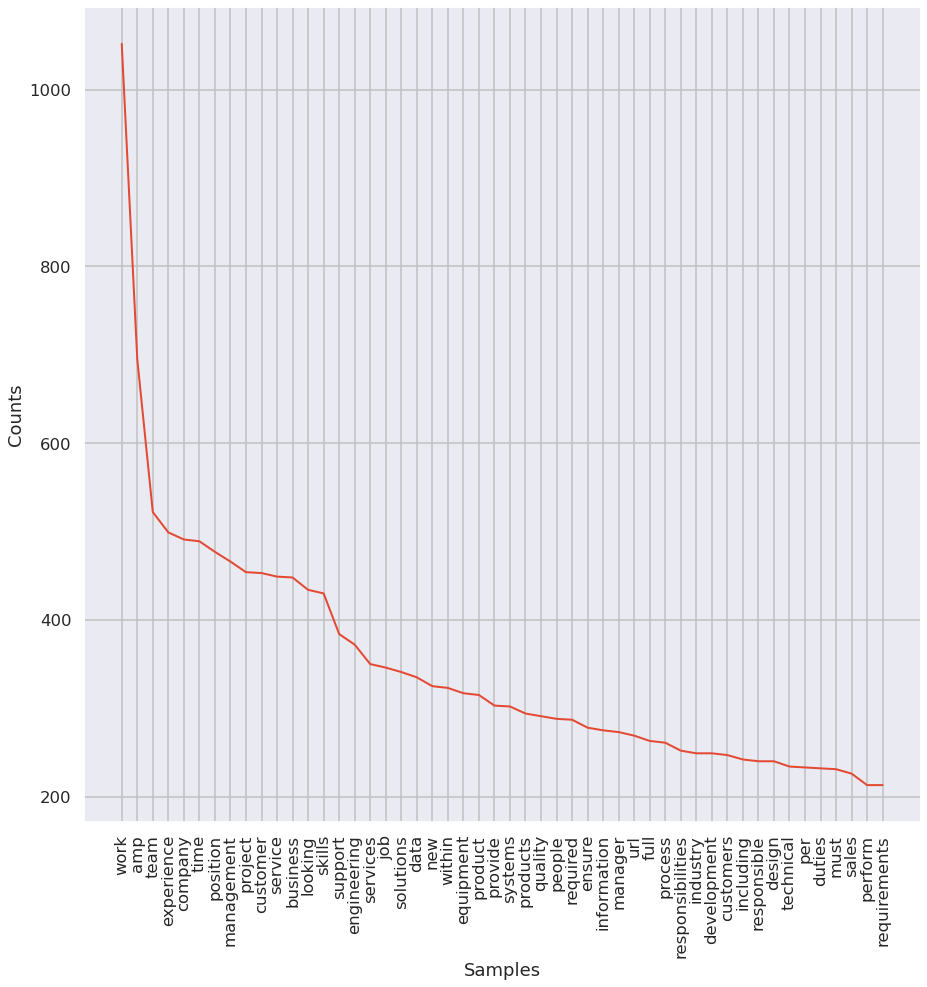

In [48]:
FreqDist(tokens_cp).plot(50)
plt.show()

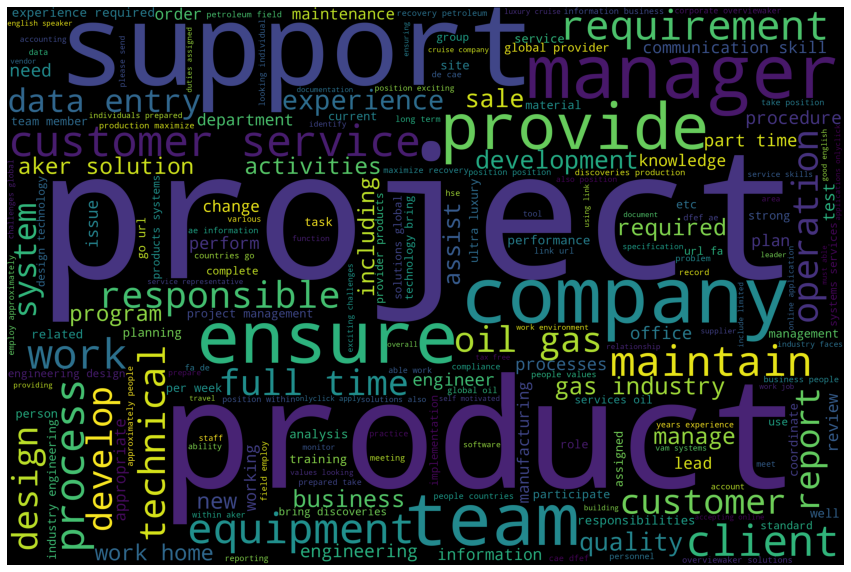

In [49]:
wordcloud = WordCloud(width = 3000,
                      height = 2000,
                      stopwords = stop_words)

wordcloud.generate(" ".join(tokens_cp))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### 2.3.2.2 Description of Legitimate Posts

In [50]:
tokens = []
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

for profile in dflegit['Description']:
    if isinstance(profile, str):
        tokenized_profile = tokenizer.tokenize(profile)
        for word in tokenized_profile:
            tokens.append(word.lower())
    else:
        tokens.append('0')

tokens_cp = [word for word in tokens if word not in stop_words]

In [51]:
len(tokens_cp)
# 948364 for df
# 18771 for dffraud
# 1019554 for dflegit

1911962

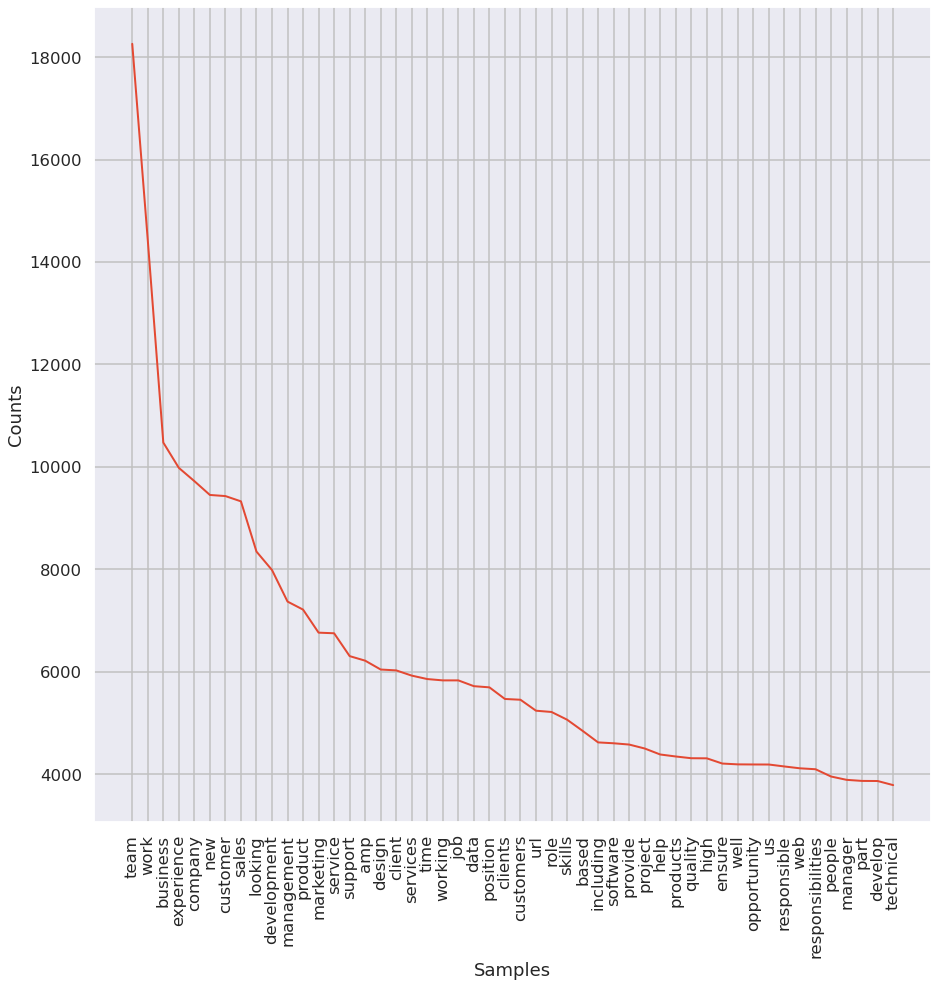

In [52]:
FreqDist(tokens_cp).plot(50)
plt.show()

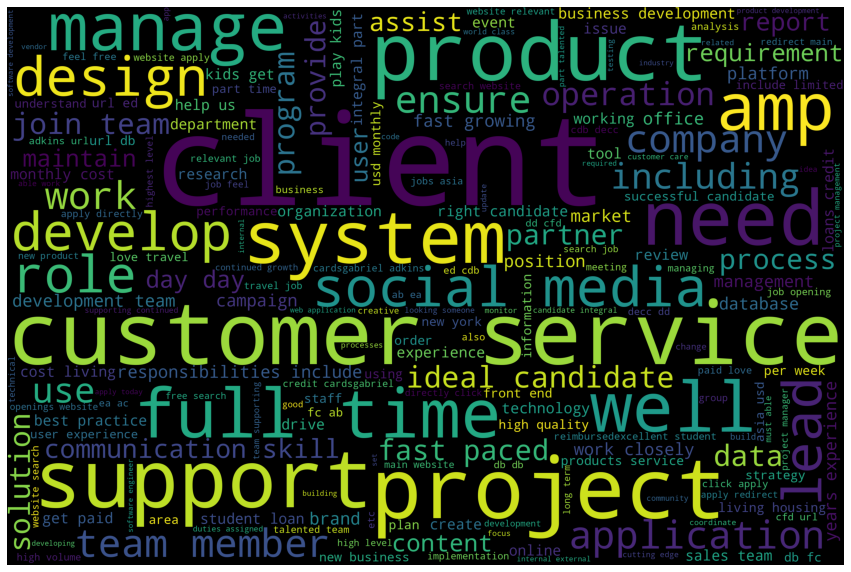

In [53]:
wordcloud = WordCloud(width = 3000,
                      height = 2000,
                      stopwords = stop_words)

wordcloud.generate(" ".join(tokens_cp))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### 2.3.3 Requirements

In [54]:
tokens = []
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

for profile in df['Requirements']:
    if isinstance(profile, str):
        tokenized_profile = tokenizer.tokenize(profile)
        for word in tokenized_profile:
            tokens.append(word.lower())
    else:
        tokens.append('0')

tokens_cp = [word for word in tokens if word not in stop_words]

In [55]:
vocab = {}
for i in tokens_cp:
    vocab[i] = vocab.get(i, 0) + 1

for i, t in enumerate(sorted(vocab.items(), key=lambda x:x[1], reverse=True), start=1):
    print(i, t)

1 ('experience', 30876)
2 ('skills', 16962)
3 ('ability', 13217)
4 ('work', 10561)
5 ('knowledge', 8247)
6 ('years', 8096)
7 ('required', 7562)
8 ('strong', 7533)
9 ('must', 6451)
10 ('excellent', 5785)
11 ('team', 5682)
12 ('communication', 5656)
13 ('management', 5640)
14 ('working', 5377)
15 ('environment', 5270)
16 ('degree', 5256)
17 ('development', 4987)
18 ('preferred', 4759)
19 ('business', 4506)
20 ('design', 4418)
21 ('written', 4118)
22 ('able', 4057)
23 ('sales', 4050)
24 ('customer', 3981)
25 ('high', 3798)
26 ('understanding', 3750)
27 ('plus', 3637)
28 ('good', 3463)
29 ('software', 3333)
30 ('minimum', 3301)
31 ('requirements', 3240)
32 ('marketing', 3128)
33 ('service', 3032)
34 ('related', 3000)
35 ('data', 2962)
36 ('time', 2943)
37 ('including', 2818)
38 ('computer', 2792)
39 ('technical', 2650)
40 ('english', 2594)
41 ('verbal', 2520)
42 ('project', 2429)
43 ('qualifications', 2427)
44 ('systems', 2253)
45 ('well', 2226)
46 ('equivalent', 2188)
47 ('product', 2103)

1689 ('outlined', 78)
1690 ('institutions', 78)
1691 ('alpha', 78)
1692 ('receive', 77)
1693 ('strict', 77)
1694 ('express', 77)
1695 ('autonomously', 77)
1696 ('constant', 77)
1697 ('incoming', 77)
1698 ('flows', 77)
1699 ('disability', 77)
1700 ('visualization', 77)
1701 ('functionality', 77)
1702 ('eligible', 77)
1703 ('labor', 77)
1704 ('officer', 77)
1705 ('videos', 76)
1706 ('evolving', 76)
1707 ('facility', 76)
1708 ('super', 76)
1709 ('specialized', 76)
1710 ('manual', 76)
1711 ('prioritizing', 76)
1712 ('ground', 76)
1713 ('talking', 76)
1714 ('south', 76)
1715 ('political', 76)
1716 ('disciplined', 76)
1717 ('selection', 76)
1718 ('enhance', 76)
1719 ('qualify', 76)
1720 ('eagerness', 76)
1721 ('overhead', 76)
1722 ('peers', 76)
1723 ('apprenticeship', 75)
1724 ('pharmaceutical', 75)
1725 ('methodical', 75)
1726 ('prove', 75)
1727 ('tables', 75)
1728 ('sign', 75)
1729 ('orientated', 75)
1730 ('farmers', 75)
1731 ('children', 75)
1732 ('sharing', 75)
1733 ('annual', 75)
1734 (

2763 ('fundraising', 34)
2764 ('kept', 34)
2765 ('announcer', 34)
2766 ('division', 34)
2767 ('texas', 33)
2768 ('sdlc', 33)
2769 ('cities', 33)
2770 ('enhancement', 33)
2771 ('flawless', 33)
2772 ('instrumentation', 33)
2773 ('diligent', 33)
2774 ('mockups', 33)
2775 ('embrace', 33)
2776 ('resident', 33)
2777 ('families', 33)
2778 ('empathetic', 33)
2779 ('mistakes', 33)
2780 ('orally', 33)
2781 ('shares', 33)
2782 ('segmentation', 33)
2783 ('waterfall', 33)
2784 ('packet', 33)
2785 ('cluster', 33)
2786 ('conceptualize', 33)
2787 ('viral', 33)
2788 ('rationale', 33)
2789 ('auditing', 33)
2790 ('relates', 33)
2791 ('belief', 33)
2792 ('procedure', 33)
2793 ('wanting', 33)
2794 ('hunter', 33)
2795 ('taken', 33)
2796 ('provisioning', 33)
2797 ('concrete', 33)
2798 ('hybrid', 33)
2799 ('measuring', 33)
2800 ('grade', 33)
2801 ('accountant', 33)
2802 ('tolerance', 33)
2803 ('subjects', 33)
2804 ('giving', 33)
2805 ('internals', 33)
2806 ('xero', 33)
2807 ('quiet', 33)
2808 ('joomla', 33)
2

4123 ('regards', 16)
4124 ('fits', 16)
4125 ('sampling', 16)
4126 ('agree', 16)
4127 ('pertinent', 16)
4128 ('outsourcing', 16)
4129 ('adjustments', 16)
4130 ('advancement', 16)
4131 ('leasing', 16)
4132 ('bamboo', 16)
4133 ('balancers', 16)
4134 ('lived', 16)
4135 ('addressed', 16)
4136 ('linear', 16)
4137 ('vector', 16)
4138 ('pivotal', 16)
4139 ('evangelize', 16)
4140 ('billion', 16)
4141 ('double', 16)
4142 ('romanian', 16)
4143 ('clothing', 16)
4144 ('none', 16)
4145 ('aspect', 16)
4146 ('shore', 16)
4147 ('forefront', 16)
4148 ('ranking', 16)
4149 ('painting', 16)
4150 ('prompt', 16)
4151 ('wireframe', 16)
4152 ('karma', 16)
4153 ('optimizations', 16)
4154 ('vibrant', 16)
4155 ('accomplishments', 16)
4156 ('investigative', 16)
4157 ('forums', 16)
4158 ('modes', 16)
4159 ('malware', 16)
4160 ('pair', 16)
4161 ('tidy', 16)
4162 ('promise', 16)
4163 ('clusters', 16)
4164 ('permanently', 16)
4165 ('solidworks', 16)
4166 ('millions', 16)
4167 ('trivial', 16)
4168 ('lock', 16)
4169 ('c

5583 ('tweak', 9)
5584 ('happiness', 9)
5585 ('initiates', 9)
5586 ('sentry', 9)
5587 ('branching', 9)
5588 ('mutually', 9)
5589 ('passionately', 9)
5590 ('responsibly', 9)
5591 ('politics', 9)
5592 ('symbol', 9)
5593 ('repairing', 9)
5594 ('excess', 9)
5595 ('plusb', 9)
5596 ('ccnp', 9)
5597 ('blood', 9)
5598 ('ideation', 9)
5599 ('wifi', 9)
5600 ('solicit', 9)
5601 ('logo', 9)
5602 ('actionscript', 9)
5603 ('buzzwords', 9)
5604 ('locum', 9)
5605 ('modifications', 9)
5606 ('outputs', 9)
5607 ('specializes', 9)
5608 ('superintendent', 9)
5609 ('rule', 9)
5610 ('offsite', 9)
5611 ('persuasiveness', 9)
5612 ('timings', 9)
5613 ('hate', 9)
5614 ('cissp', 9)
5615 ('uncover', 9)
5616 ('macintosh', 9)
5617 ('shortly', 9)
5618 ('federation', 9)
5619 ('baccalaureate', 9)
5620 ('wisdom', 9)
5621 ('paradigm', 9)
5622 ('fareast', 9)
5623 ('unfamiliar', 9)
5624 ('billions', 9)
5625 ('mongoose', 9)
5626 ('cedexis', 9)
5627 ('hardening', 9)
5628 ('laminating', 9)
5629 ('counts', 8)
5630 ('pacific', 

6938 ('assorted', 5)
6939 ('inner', 5)
6940 ('awhile', 5)
6941 ('concepting', 5)
6942 ('optometric', 5)
6943 ('optom', 5)
6944 ('ophthalmic', 5)
6945 ('phoenix', 5)
6946 ('grownic', 5)
6947 ('parallelism', 5)
6948 ('throughput', 5)
6949 ('mindful', 5)
6950 ('winds', 5)
6951 ('realize', 5)
6952 ('ignored', 5)
6953 ('impactfull', 5)
6954 ('callouts', 5)
6955 ('trainin', 5)
6956 ('tradeshows', 5)
6957 ('welcomes', 5)
6958 ('radian', 5)
6959 ('perspectives', 5)
6960 ('tense', 5)
6961 ('sonic', 5)
6962 ('worldspan', 5)
6963 ('oper', 5)
6964 ('christ', 5)
6965 ('microcontroller', 5)
6966 ('topologies', 5)
6967 ('rejection', 5)
6968 ('severe', 5)
6969 ('roof', 5)
6970 ('sandfield', 5)
6971 ('porte', 5)
6972 ('draper', 5)
6973 ('installers', 5)
6974 ('microstrategy', 5)
6975 ('pressurize', 5)
6976 ('jobsite', 5)
6977 ('dublin', 5)
6978 ('mails', 5)
6979 ('realtime', 5)
6980 ('showcases', 5)
6981 ('arriving', 5)
6982 ('handicaps', 5)
6983 ('mantoux', 5)
6984 ('terminate', 5)
6985 ('reflected', 

8572 ('fisma', 3)
8573 ('operationally', 3)
8574 ('rightscale', 3)
8575 ('spearhead', 3)
8576 ('fingerprinting', 3)
8577 ('breathed', 3)
8578 ('transformed', 3)
8579 ('stylish', 3)
8580 ('superpower', 3)
8581 ('martin', 3)
8582 ('gemfire', 3)
8583 ('terracotta', 3)
8584 ('hyperic', 3)
8585 ('actional', 3)
8586 ('bacon', 3)
8587 ('century', 3)
8588 ('variate', 3)
8589 ('academically', 3)
8590 ('logistic', 3)
8591 ('sjvacd', 3)
8592 ('carb', 3)
8593 ('doggr', 3)
8594 ('spill', 3)
8595 ('spcc', 3)
8596 ('waresthink', 3)
8597 ('ideashave', 3)
8598 ('uphave', 3)
8599 ('timer', 3)
8600 ('exemplify', 3)
8601 ('quadcopters', 3)
8602 ('potato', 3)
8603 ('launchers', 3)
8604 ('patras', 3)
8605 ('cracker', 3)
8606 ('agitators', 3)
8607 ('enjoyment', 3)
8608 ('installer', 3)
8609 ('immersion', 3)
8610 ('podcasts', 3)
8611 ('valuing', 3)
8612 ('dropwizard', 3)
8613 ('boilerplate', 3)
8614 ('returning', 3)
8615 ('establishment', 3)
8616 ('intrigued', 3)
8617 ('jboss', 3)
8618 ('geeky', 3)
8619 ('inn

10044 ('brutto', 2)
10045 ('unaided', 2)
10046 ('engineeringio', 2)
10047 ('orienting', 2)
10048 ('feelgood', 2)
10049 ('sorrows', 2)
10050 ('appeitite', 2)
10051 ('hide', 2)
10052 ('anonymous', 2)
10053 ('openid', 2)
10054 ('orcaflex', 2)
10055 ('issa', 2)
10056 ('baseline', 2)
10057 ('textual', 2)
10058 ('representations', 2)
10059 ('salaries', 2)
10060 ('opera', 2)
10061 ('mustand', 2)
10062 ('projectexperience', 2)
10063 ('complexityindependently', 2)
10064 ('businessrequirements', 2)
10065 ('availablebest', 2)
10066 ('indeveloping', 2)
10067 ('deliverycompetency', 2)
10068 ('developedreusable', 2)
10069 ('technologyframeworks', 2)
10070 ('intendeddelivery', 2)
10071 ('technologicalintegration', 2)
10072 ('ofdeveloping', 2)
10073 ('overiew', 2)
10074 ('shells', 2)
10075 ('bourne', 2)
10076 ('kshrc', 2)
10077 ('forautomatic', 2)
10078 ('redirection', 2)
10079 ('aliases', 2)
10080 ('unalias', 2)
10081 ('unset', 2)
10082 ('andpredefined', 2)
10083 ('exporting', 2)
10084 ('filesand', 2

11609 ('equipping', 2)
11610 ('flexibl', 2)
11611 ('exploitable', 2)
11612 ('resetting', 2)
11613 ('instructing', 2)
11614 ('airenvy', 2)
11615 ('practioner', 2)
11616 ('altiris', 2)
11617 ('ridiculous', 2)
11618 ('rackspacecloud', 2)
11619 ('psych', 2)
11620 ('dean', 2)
11621 ('desserts', 2)
11622 ('convenience', 2)
11623 ('systemschs', 2)
11624 ('desirableosh', 2)
11625 ('beneficiali', 2)
11626 ('swif', 2)
11627 ('handlers', 2)
11628 ('cygwin', 2)
11629 ('responsibilty', 2)
11630 ('netezza', 2)
11631 ('securitization', 2)
11632 ('exams', 2)
11633 ('locals', 2)
11634 ('yesware', 2)
11635 ('honing', 2)
11636 ('garage', 2)
11637 ('eventual', 2)
11638 ('parker', 2)
11639 ('explanatory', 2)
11640 ('drops', 2)
11641 ('invested', 2)
11642 ('degreein', 2)
11643 ('inmanagerial', 2)
11644 ('reaction', 2)
11645 ('orthe', 2)
11646 ('exerience', 2)
11647 ('polycom', 2)
11648 ('lathe', 2)
11649 ('requiredpreferred', 2)
11650 ('whey', 2)
11651 ('iaeducation', 2)
11652 ('webrtc', 2)
11653 ('ageoc', 

12915 ('mandatoryt', 1)
12916 ('gurgaon', 1)
12917 ('porftolio', 1)
12918 ('proactiveability', 1)
12919 ('initiativea', 1)
12920 ('malayalam', 1)
12921 ('kannada', 1)
12922 ('tamil', 1)
12923 ('tice', 1)
12924 ('reinvest', 1)
12925 ('rationalization', 1)
12926 ('emphasizing', 1)
12927 ('cogently', 1)
12928 ('boto', 1)
12929 ('livescan', 1)
12930 ('illnesses', 1)
12931 ('sympathetic', 1)
12932 ('suffering', 1)
12933 ('stresses', 1)
12934 ('welder', 1)
12935 ('experiencepp', 1)
12936 ('experiencecm', 1)
12937 ('reducejav', 1)
12938 ('databaseset', 1)
12939 ('detailmethodicalproactivea', 1)
12940 ('outings', 1)
12941 ('nvql', 1)
12942 ('dipcg', 1)
12943 ('unfazed', 1)
12944 ('bufferapp', 1)
12945 ('renown', 1)
12946 ('productshave', 1)
12947 ('stackdemand', 1)
12948 ('testingare', 1)
12949 ('membershave', 1)
12950 ('beforehave', 1)
12951 ('codehave', 1)
12952 ('yoube', 1)
12953 ('zonelove', 1)
12954 ('occurred', 1)
12955 ('seriousness', 1)
12956 ('employability', 1)
12957 ('chatting', 1)


14425 ('applicationssoa', 1)
14426 ('latvian', 1)
14427 ('criticise', 1)
14428 ('lldp', 1)
14429 ('concentrator', 1)
14430 ('workmanship', 1)
14431 ('anybody', 1)
14432 ('nearer', 1)
14433 ('webfonts', 1)
14434 ('qualificationprevious', 1)
14435 ('environmentat', 1)
14436 ('net', 1)
14437 ('regimented', 1)
14438 ('saturating', 1)
14439 ('touchstone', 1)
14440 ('cleveland', 1)
14441 ('louisville', 1)
14442 ('lexington', 1)
14443 ('nashville', 1)
14444 ('louis', 1)
14445 ('pittsburgh', 1)
14446 ('wayne', 1)
14447 ('constructio', 1)
14448 ('environmentny', 1)
14449 ('tcipip', 1)
14450 ('libgdx', 1)
14451 ('sony', 1)
14452 ('airplane', 1)
14453 ('campaigners', 1)
14454 ('methodologyprince', 1)
14455 ('flexibile', 1)
14456 ('laudering', 1)
14457 ('renderman', 1)
14458 ('cabaility', 1)
14459 ('knoledge', 1)
14460 ('songhai', 1)
14461 ('compiliation', 1)
14462 ('jayne', 1)
14463 ('aspexrecruitment', 1)
14464 ('aspex', 1)
14465 ('litigator', 1)
14466 ('technicals', 1)
14467 ('sloth', 1)
14468 

16025 ('recoveryo', 1)
16026 ('workloado', 1)
16027 ('environmento', 1)
16028 ('certificationo', 1)
16029 ('espouse', 1)
16030 ('grander', 1)
16031 ('resevations', 1)
16032 ('abilty', 1)
16033 ('welders', 1)
16034 ('requried', 1)
16035 ('railsexperience', 1)
16036 ('angularknowledge', 1)
16037 ('queryexperience', 1)
16038 ('applicationsa', 1)
16039 ('designpassion', 1)
16040 ('codegood', 1)
16041 ('databasesworking', 1)
16042 ('moustache', 1)
16043 ('idioms', 1)
16044 ('ethusiastic', 1)
16045 ('intricate', 1)
16046 ('fibreoptic', 1)
16047 ('calculationts', 1)
16048 ('asshole', 1)
16049 ('exemplifying', 1)
16050 ('teamingqualifications', 1)
16051 ('radionuclidic', 1)
16052 ('dmaic', 1)
16053 ('manipulations', 1)
16054 ('backgound', 1)
16055 ('erste', 1)
16056 ('vertriebserfahrung', 1)
16057 ('zielstrebig', 1)
16058 ('skillsethtml', 1)
16059 ('advantagous', 1)
16060 ('revolving', 1)
16061 ('begins', 1)
16062 ('nucleus', 1)
16063 ('traning', 1)
16064 ('matched', 1)
16065 ('strat', 1)
1606

17322 ('displacements', 1)
17323 ('mannerrequire', 1)
17324 ('stairwells', 1)
17325 ('protrusions', 1)
17326 ('tagalog', 1)
17327 ('quarry', 1)
17328 ('epoxy', 1)
17329 ('grouts', 1)
17330 ('meshes', 1)
17331 ('freehand', 1)
17332 ('storyboarding', 1)
17333 ('ironpython', 1)
17334 ('bossyou', 1)
17335 ('classyou', 1)
17336 ('ownyou', 1)
17337 ('techniqueswe', 1)
17338 ('attitudem', 1)
17339 ('aing', 1)
17340 ('denvelopment', 1)
17341 ('kaunas', 1)
17342 ('platformsenterprise', 1)
17343 ('developmentall', 1)
17344 ('skid', 1)
17345 ('steers', 1)
17346 ('hoes', 1)
17347 ('excavators', 1)
17348 ('articulated', 1)
17349 ('dozers', 1)
17350 ('tandem', 1)
17351 ('bagging', 1)
17352 ('heavilymvchtm', 1)
17353 ('transcripts', 1)
17354 ('munki', 1)
17355 ('crashplan', 1)
17356 ('emulate', 1)
17357 ('projectseducatio', 1)
17358 ('projectspm', 1)
17359 ('nurtured', 1)
17360 ('irtual', 1)
17361 ('lingos', 1)
17362 ('wages', 1)
17363 ('ironically', 1)
17364 ('bylines', 1)
17365 ('beaming', 1)
17366

18840 ('managermc', 1)
18841 ('bods', 1)
18842 ('berkeley', 1)
18843 ('lucid', 1)
18844 ('palette', 1)
18845 ('experienceuspto', 1)
18846 ('prosecuting', 1)
18847 ('puts', 1)
18848 ('gtfs', 1)
18849 ('blown', 1)
18850 ('arrogant', 1)
18851 ('witted', 1)
18852 ('handcoding', 1)
18853 ('dchp', 1)
18854 ('subnets', 1)
18855 ('paraphrasing', 1)
18856 ('overtones', 1)
18857 ('intents', 1)
18858 ('acceptably', 1)
18859 ('imperfections', 1)
18860 ('pauses', 1)
18861 ('proverbs', 1)
18862 ('idiom', 1)
18863 ('inaccuracy', 1)
18864 ('misunderstanding', 1)
18865 ('oflander', 1)
18866 ('dockhiemer', 1)
18867 ('certificationsccnaiti', 1)
18868 ('brainbench', 1)
18869 ('corner', 1)
18870 ('postrgresql', 1)
18871 ('userpractices', 1)
18872 ('hping', 1)
18873 ('traceroute', 1)
18874 ('netstat', 1)
18875 ('rebasing', 1)
18876 ('squeel', 1)
18877 ('delayed', 1)
18878 ('job', 1)
18879 ('formtastic', 1)
18880 ('pdf', 1)
18881 ('faye', 1)
18882 ('coolant', 1)
18883 ('readout', 1)
18884 ('dials', 1)
18885 

#### 2.3.3.1 Requirements of Fraudulent Posts

In [56]:
tokens = []
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

for profile in dffraud['Requirements']:
    if isinstance(profile, str):
        tokenized_profile = tokenizer.tokenize(profile)
        for word in tokenized_profile:
            tokens.append(word.lower())
    else:
        tokens.append('0')

tokens_cp = [word for word in tokens if word not in stop_words]

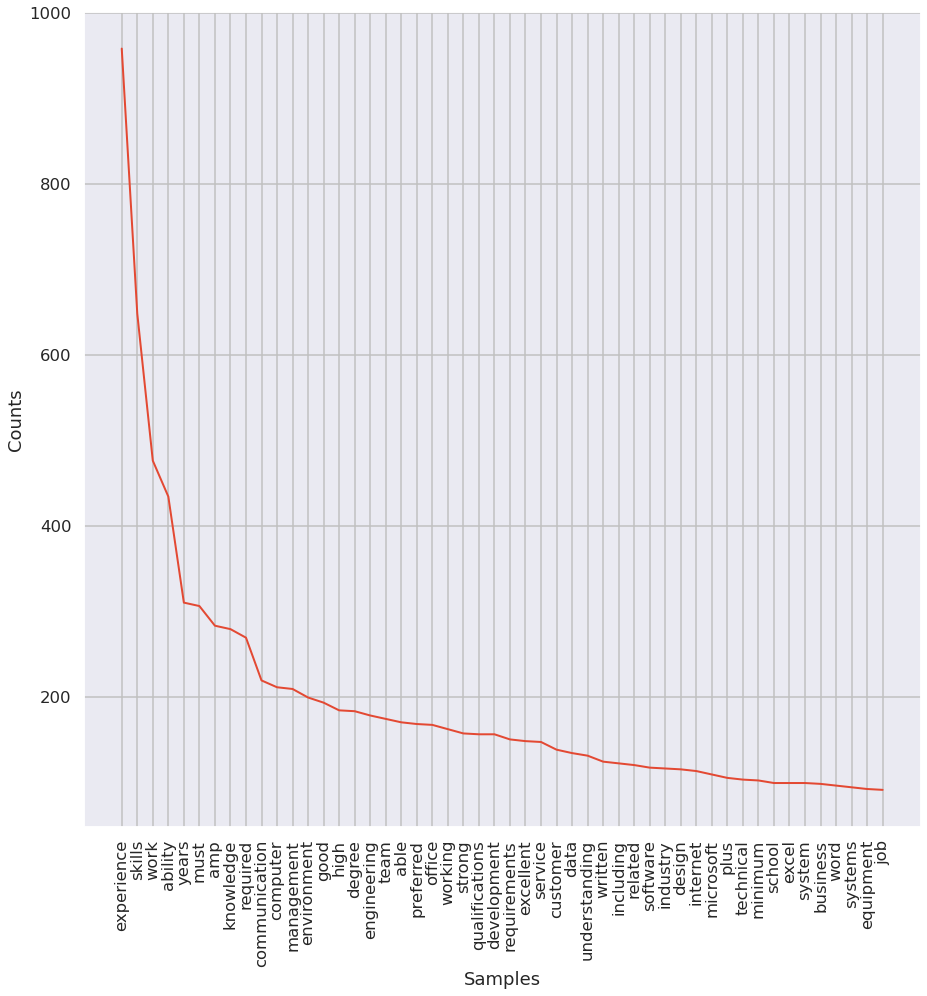

In [57]:
FreqDist(tokens_cp).plot(50)
plt.show()

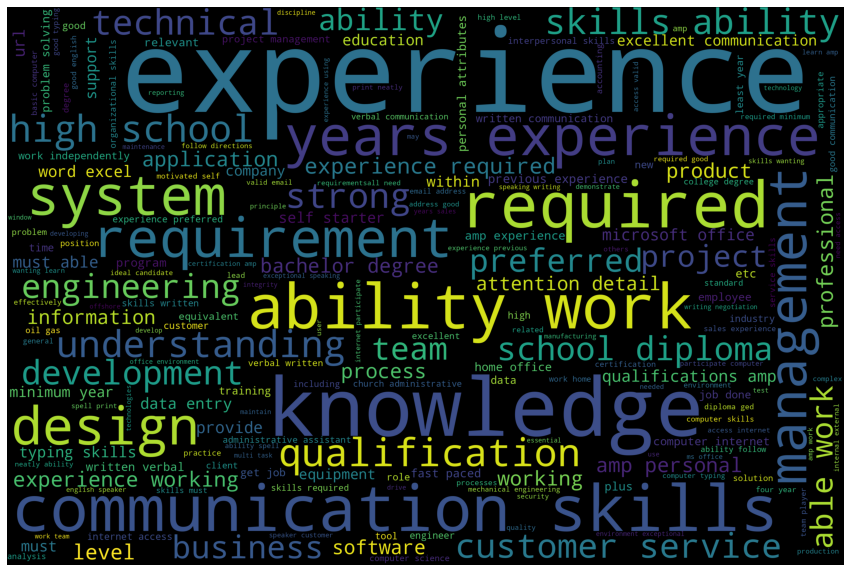

In [58]:
wordcloud = WordCloud(width = 3000,
                      height = 2000,
                      stopwords = stop_words)

wordcloud.generate(" ".join(tokens_cp))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### 2.3.3.2 Description of Requirements Posts

In [59]:
tokens = []
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

for profile in dflegit['Requirements']:
    if isinstance(profile, str):
        tokenized_profile = tokenizer.tokenize(profile)
        for word in tokenized_profile:
            tokens.append(word.lower())
    else:
        tokens.append('0')

tokens_cp = [word for word in tokens if word not in stop_words]

In [60]:
len(tokens_cp)
# 948364 for df
# 18771 for dffraud
# 1019554 for dflegit

946331

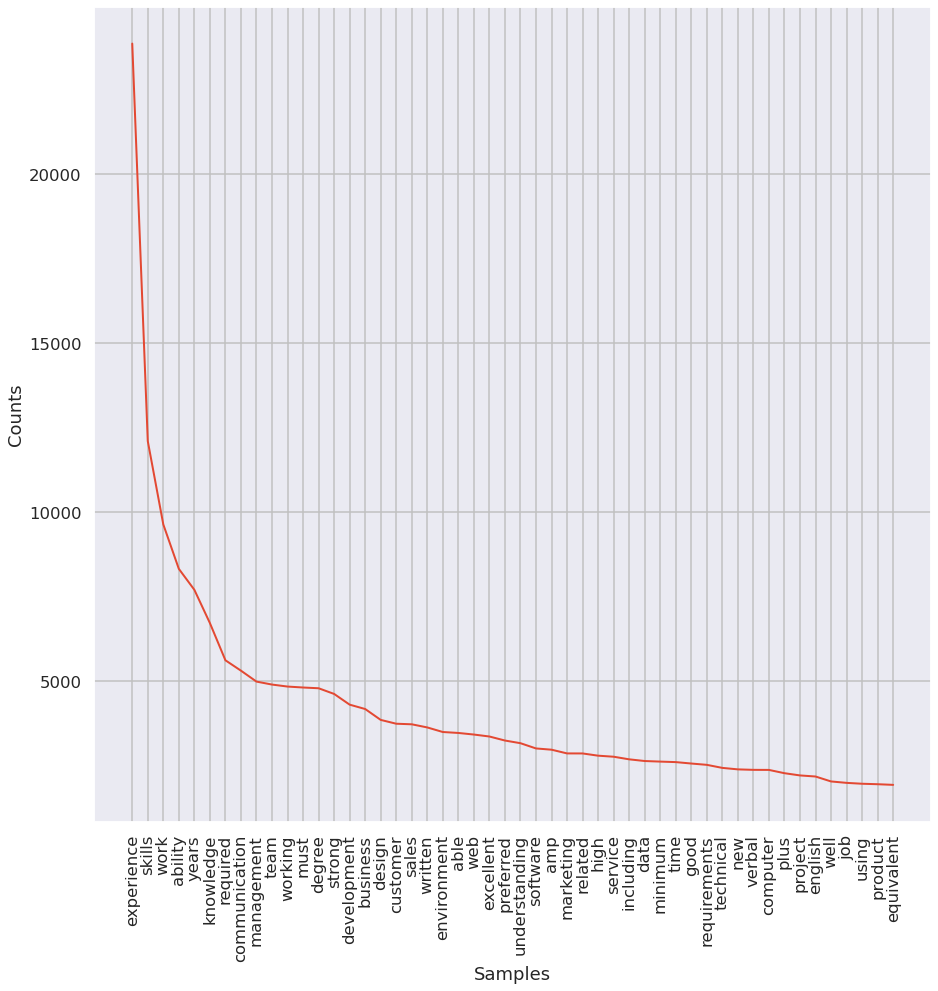

In [61]:
FreqDist(tokens_cp).plot(50)
plt.show()

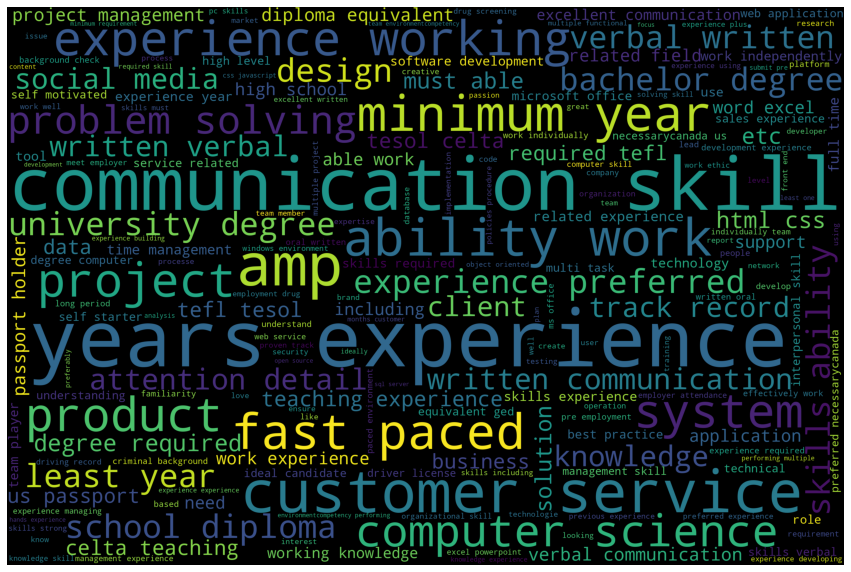

In [62]:
wordcloud = WordCloud(width = 3000,
                      height = 2000,
                      stopwords = stop_words)

wordcloud.generate(" ".join(tokens_cp))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### 2.3.4 Benefits

In [63]:
tokens = []
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

for profile in df['Benefits']:
    if isinstance(profile, str):
        tokenized_profile = tokenizer.tokenize(profile)
        for word in tokenized_profile:
            tokens.append(word.lower())
    else:
        tokens.append('0')

tokens_cp = [word for word in tokens if word not in stop_words]

In [64]:
vocab = {}
for i in tokens_cp:
    vocab[i] = vocab.get(i, 0) + 1

for i, t in enumerate(sorted(vocab.items(), key=lambda x:x[1], reverse=True), start=1):
    print(i, t)

1 ('work', 4975)
2 ('benefits', 4291)
3 ('company', 3829)
4 ('competitive', 3395)
5 ('paid', 3038)
6 ('team', 3014)
7 ('salary', 2952)
8 ('insurance', 2648)
9 ('time', 2540)
10 ('full', 2190)
11 ('environment', 2127)
12 ('dental', 2117)
13 ('health', 2066)
14 ('offer', 2063)
15 ('opportunity', 2046)
16 ('working', 1905)
17 ('package', 1859)
18 ('life', 1721)
19 ('medical', 1670)
20 ('training', 1630)
21 ('vacation', 1600)
22 ('experience', 1555)
23 ('plan', 1506)
24 ('hours', 1458)
25 ('free', 1449)
26 ('great', 1433)
27 ('flexible', 1399)
28 ('vision', 1345)
29 ('days', 1332)
30 ('career', 1308)
31 ('people', 1288)
32 ('opportunities', 1262)
33 ('based', 1221)
34 ('employment', 1219)
35 ('including', 1212)
36 ('office', 1206)
37 ('compensation', 1151)
38 ('employees', 1148)
39 ('part', 1118)
40 ('holidays', 1113)
41 ('year', 1092)
42 ('well', 1067)
43 ('development', 1028)
44 ('please', 1024)
45 ('world', 1020)
46 ('growing', 973)
47 ('also', 970)
48 ('business', 954)
49 ('employee', 

1682 ('accessible', 27)
1683 ('desire', 27)
1684 ('doors', 27)
1685 ('honest', 27)
1686 ('highlights', 27)
1687 ('face', 27)
1688 ('consultant', 27)
1689 ('franchise', 27)
1690 ('identification', 27)
1691 ('decision', 26)
1692 ('clear', 26)
1693 ('http', 26)
1694 ('corporation', 26)
1695 ('printing', 26)
1696 ('additive', 26)
1697 ('taylor', 26)
1698 ('ewen', 26)
1699 ('fulfillment', 26)
1700 ('austin', 26)
1701 ('genomics', 26)
1702 ('medicine', 26)
1703 ('hackdays', 26)
1704 ('recently', 26)
1705 ('substantial', 26)
1706 ('police', 26)
1707 ('qualifying', 26)
1708 ('tactics', 26)
1709 ('consists', 26)
1710 ('worth', 26)
1711 ('words', 26)
1712 ('sustainable', 26)
1713 ('referring', 26)
1714 ('display', 26)
1715 ('enviable', 26)
1716 ('germany', 26)
1717 ('submitted', 26)
1718 ('gold', 26)
1719 ('bonfire', 26)
1720 ('boot', 26)
1721 ('handicap', 26)
1722 ('invited', 25)
1723 ('license', 25)
1724 ('exchange', 25)
1725 ('limit', 25)
1726 ('west', 25)
1727 ('miami', 25)
1728 ('rooms', 25

2994 ('pintcareers', 10)
2995 ('laugh', 10)
2996 ('accordingly', 10)
2997 ('rules', 10)
2998 ('dozens', 10)
2999 ('assortment', 10)
3000 ('sponsor', 10)
3001 ('impressive', 10)
3002 ('meetups', 10)
3003 ('contests', 10)
3004 ('easily', 10)
3005 ('wanting', 10)
3006 ('overlap', 10)
3007 ('fraud', 10)
3008 ('mondelez', 10)
3009 ('welcomed', 10)
3010 ('moment', 10)
3011 ('bitcoins', 10)
3012 ('vietnam', 10)
3013 ('learns', 10)
3014 ('veel', 10)
3015 ('combines', 10)
3016 ('exercise', 10)
3017 ('january', 10)
3018 ('spotify', 10)
3019 ('practical', 10)
3020 ('singular', 10)
3021 ('tsakiris', 10)
3022 ('gianna', 10)
3023 ('kazakou', 10)
3024 ('suchs', 10)
3025 ('intale', 10)
3026 ('segment', 10)
3027 ('secrets', 10)
3028 ('mechanism', 10)
3029 ('tripod', 10)
3030 ('lean', 10)
3031 ('communities', 10)
3032 ('midtown', 10)
3033 ('routes', 10)
3034 ('grand', 10)
3035 ('visah', 10)
3036 ('revolutionizing', 10)
3037 ('annuity', 10)
3038 ('undisputed', 10)
3039 ('vitae', 10)
3040 ('lakhs', 10)
30

4274 ('jungle', 5)
4275 ('shapes', 5)
4276 ('linkwise', 5)
4277 ('hitting', 5)
4278 ('reformation', 5)
4279 ('maintained', 5)
4280 ('runs', 5)
4281 ('selectable', 5)
4282 ('affiliate', 5)
4283 ('attendances', 5)
4284 ('yummy', 5)
4285 ('incl', 5)
4286 ('screens', 5)
4287 ('capitals', 5)
4288 ('assessed', 5)
4289 ('prototyping', 5)
4290 ('bulls', 5)
4291 ('architectures', 5)
4292 ('bill', 5)
4293 ('male', 5)
4294 ('locator', 5)
4295 ('region', 5)
4296 ('moments', 5)
4297 ('bachelor', 5)
4298 ('purposes', 5)
4299 ('heath', 5)
4300 ('roundabout', 5)
4301 ('district', 5)
4302 ('pressure', 5)
4303 ('companys', 5)
4304 ('doctor', 5)
4305 ('purposefully', 5)
4306 ('inviting', 5)
4307 ('companionship', 5)
4308 ('motley', 5)
4309 ('cast', 5)
4310 ('mutts', 5)
4311 ('roots', 5)
4312 ('satisfying', 5)
4313 ('suits', 5)
4314 ('trainees', 5)
4315 ('cream', 5)
4316 ('uniforms', 5)
4317 ('treatment', 5)
4318 ('writers', 5)
4319 ('insure', 5)
4320 ('effect', 5)
4321 ('opinion', 5)
4322 ('assessment', 

5874 ('jederzeit', 2)
5875 ('anrufen', 2)
5876 ('oder', 2)
5877 ('einfach', 2)
5878 ('besuchen', 2)
5879 ('quotas', 2)
5880 ('converting', 2)
5881 ('bradley', 2)
5882 ('changed', 2)
5883 ('perrier', 2)
5884 ('jets', 2)
5885 ('scion', 2)
5886 ('concerned', 2)
5887 ('increment', 2)
5888 ('depop', 2)
5889 ('eyes', 2)
5890 ('editions', 2)
5891 ('skyline', 2)
5892 ('physio', 2)
5893 ('flexi', 2)
5894 ('diving', 2)
5895 ('modeling', 2)
5896 ('analytic', 2)
5897 ('hassle', 2)
5898 ('sume', 2)
5899 ('startupunparrelel', 2)
5900 ('usthe', 2)
5901 ('workexposure', 2)
5902 ('marketsa', 2)
5903 ('analyzing', 2)
5904 ('valo', 2)
5905 ('precise', 2)
5906 ('concerted', 2)
5907 ('foss', 2)
5908 ('koramangala', 2)
5909 ('costco', 2)
5910 ('reciprocal', 2)
5911 ('embedded', 2)
5912 ('lights', 2)
5913 ('shuts', 2)
5914 ('outfitting', 2)
5915 ('saved', 2)
5916 ('oakland', 2)
5917 ('distraction', 2)
5918 ('postings', 2)
5919 ('dating', 2)
5920 ('somebody', 2)
5921 ('signal', 2)
5922 ('ratio', 2)
5923 ('pro

7474 ('corganization', 1)
7475 ('periodsnt', 1)
7476 ('symbol', 1)
7477 ('arial', 1)
7478 ('liked', 1)
7479 ('negotiating', 1)
7480 ('envisage', 1)
7481 ('naeem', 1)
7482 ('khan', 1)
7483 ('jams', 1)
7484 ('developmental', 1)
7485 ('secular', 1)
7486 ('insite', 1)
7487 ('minneapolis', 1)
7488 ('advancements', 1)
7489 ('renovated', 1)
7490 ('collect', 1)
7491 ('noon', 1)
7492 ('versions', 1)
7493 ('cheerfulness', 1)
7494 ('lifstyle', 1)
7495 ('dolor', 1)
7496 ('consectetur', 1)
7497 ('adipiscing', 1)
7498 ('laoreet', 1)
7499 ('nulla', 1)
7500 ('facilisi', 1)
7501 ('mollis', 1)
7502 ('donec', 1)
7503 ('sodales', 1)
7504 ('felis', 1)
7505 ('ligula', 1)
7506 ('pellentesque', 1)
7507 ('placerat', 1)
7508 ('purus', 1)
7509 ('pharetra', 1)
7510 ('massa', 1)
7511 ('suspendisse', 1)
7512 ('tortor', 1)
7513 ('nisl', 1)
7514 ('fusce', 1)
7515 ('rhoncus', 1)
7516 ('iaculis', 1)
7517 ('maximus', 1)
7518 ('diam', 1)
7519 ('eleifend', 1)
7520 ('praesent', 1)
7521 ('molestie', 1)
7522 ('integer', 1)
7

8991 ('eventssandwiches', 1)
8992 ('morningtea', 1)
8993 ('planpto', 1)
8994 ('professionalbeing', 1)
8995 ('enefits', 1)
8996 ('radico', 1)
8997 ('etsy', 1)
8998 ('retouching', 1)
8999 ('occupies', 1)
9000 ('publicis', 1)
9001 ('cann', 1)
9002 ('worldgroup', 1)
9003 ('wieden', 1)
9004 ('kennedy', 1)
9005 ('est', 1)
9006 ('tommy', 1)
9007 ('hilfiger', 1)
9008 ('absolut', 1)
9009 ('vodka', 1)
9010 ('grey', 1)
9011 ('walter', 1)
9012 ('thompson', 1)
9013 ('vogue', 1)
9014 ('ashleys', 1)
9015 ('exiting', 1)
9016 ('teamevents', 1)
9017 ('telecom', 1)
9018 ('flare', 1)
9019 ('interior', 1)
9020 ('healh', 1)
9021 ('preserve', 1)
9022 ('removable', 1)
9023 ('upheld', 1)
9024 ('outlets', 1)
9025 ('milpitas', 1)
9026 ('japan', 1)
9027 ('progresses', 1)
9028 ('progressin', 1)
9029 ('launches', 1)
9030 ('lessard', 1)
9031 ('turku', 1)
9032 ('monastiraki', 1)
9033 ('helathcare', 1)
9034 ('tucson', 1)
9035 ('begining', 1)
9036 ('podio', 1)
9037 ('mailchimp', 1)
9038 ('averaging', 1)
9039 ('taskus',

#### 2.3.4.1 Requirements of Fraudulent Posts

In [65]:
tokens = []
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

for profile in dffraud['Benefits']:
    if isinstance(profile, str):
        tokenized_profile = tokenizer.tokenize(profile)
        for word in tokenized_profile:
            tokens.append(word.lower())
    else:
        tokens.append('0')

tokens_cp = [word for word in tokens if word not in stop_words]

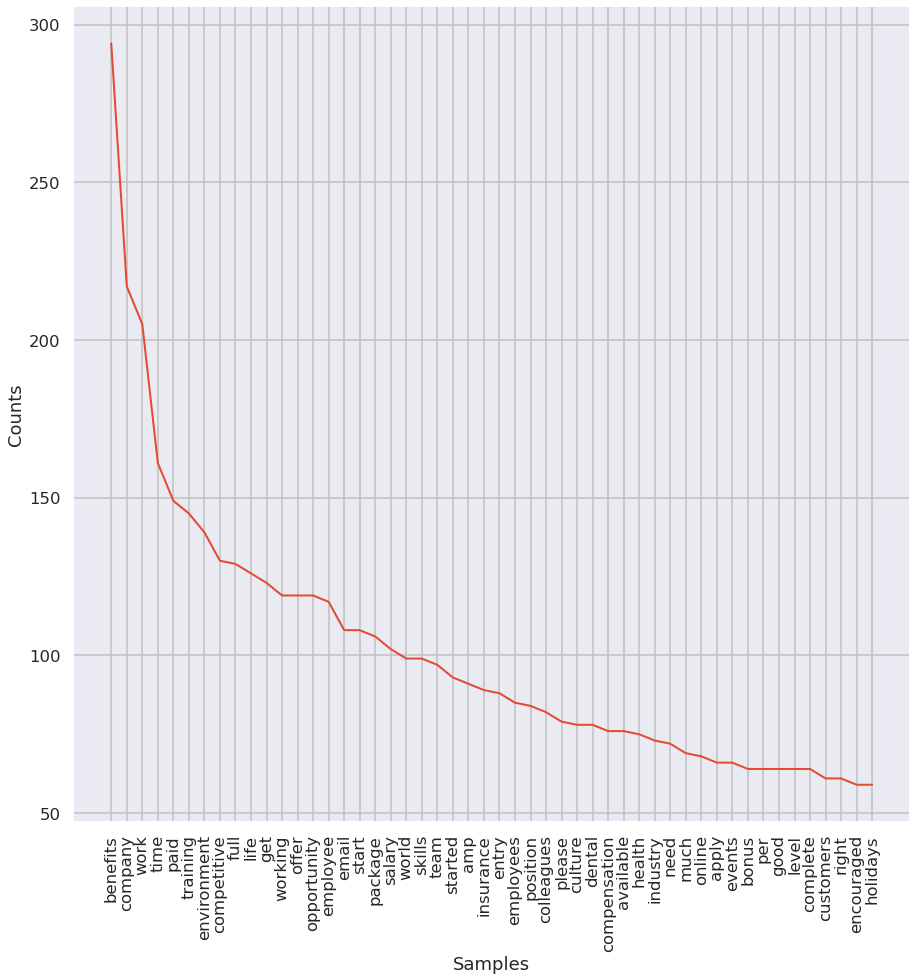

In [66]:
FreqDist(tokens_cp).plot(50)
plt.show()

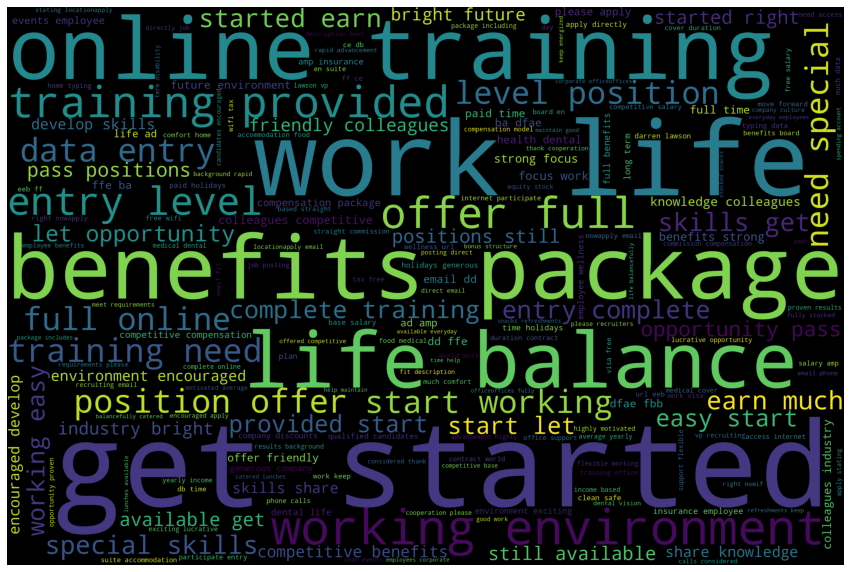

In [67]:
wordcloud = WordCloud(width = 3000,
                      height = 2000,
                      stopwords = stop_words)

wordcloud.generate(" ".join(tokens_cp))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### 2.3.4.2 Description of Requirements Posts

In [68]:
tokens = []
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

for profile in dflegit['Benefits']:
    if isinstance(profile, str):
        tokenized_profile = tokenizer.tokenize(profile)
        for word in tokenized_profile:
            tokens.append(word.lower())
    else:
        tokens.append('0')

tokens_cp = [word for word in tokens if word not in stop_words]

In [69]:
len(tokens_cp)
# 948364 for df
# 18771 for dffraud
# 1019554 for dflegit

338418

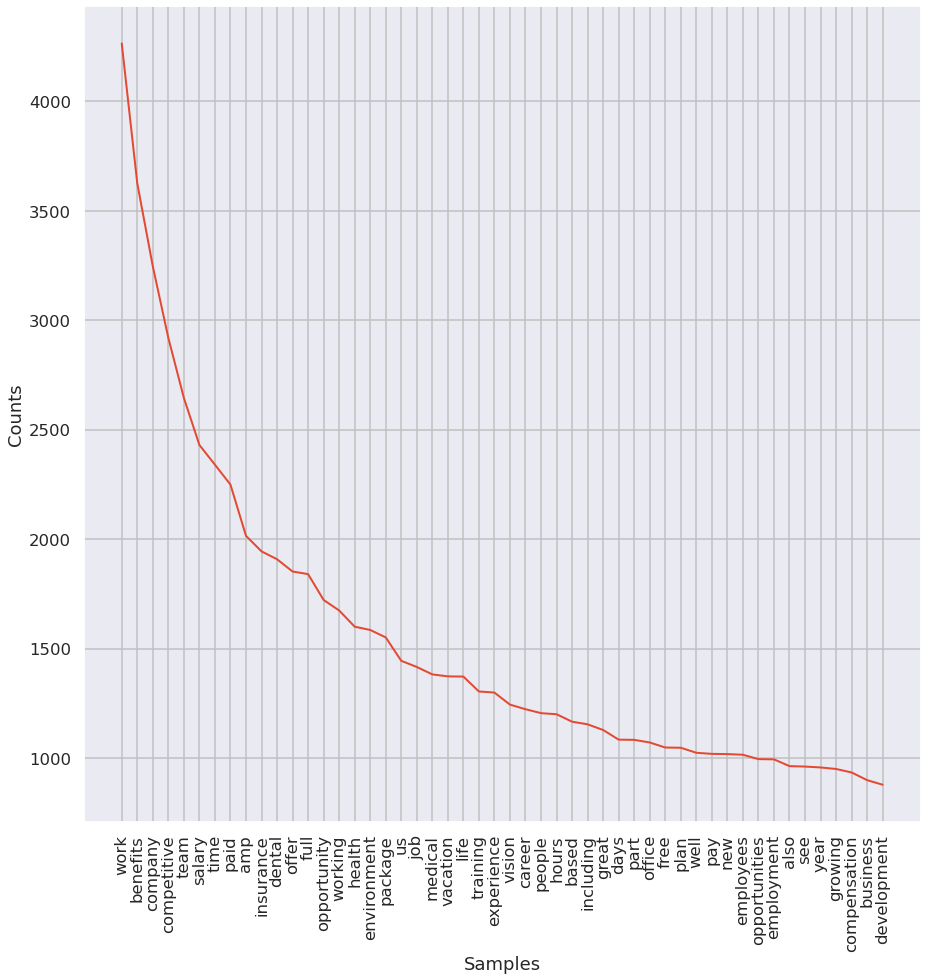

In [70]:
FreqDist(tokens_cp).plot(50)
plt.show()

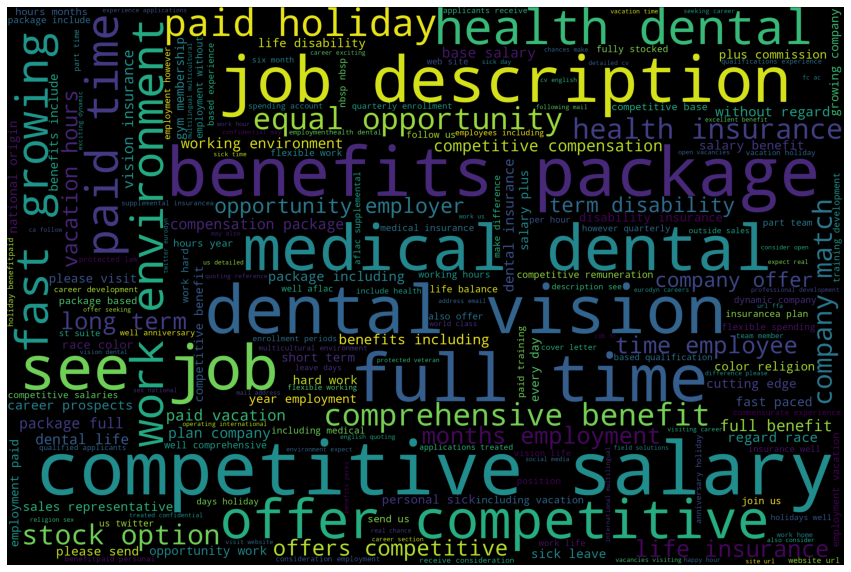

In [71]:
wordcloud = WordCloud(width = 3000,
                      height = 2000,
                      stopwords = stop_words)

wordcloud.generate(" ".join(tokens_cp))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## 3. Categorical information

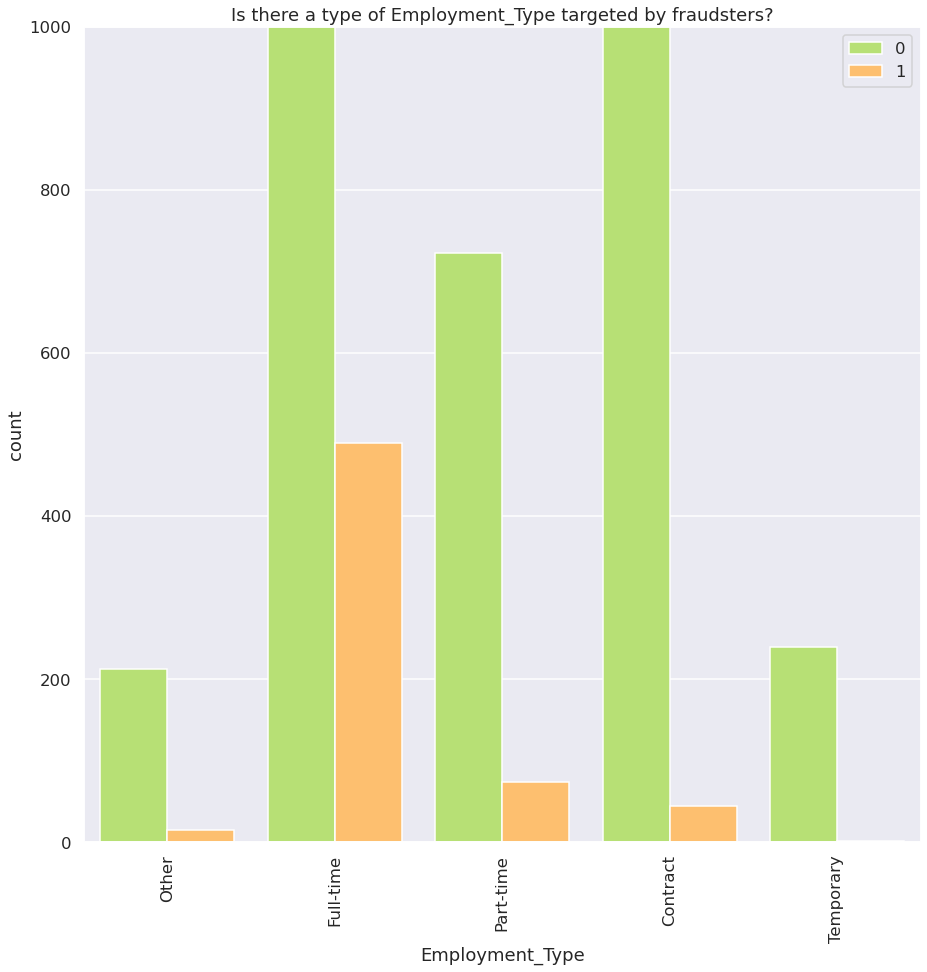

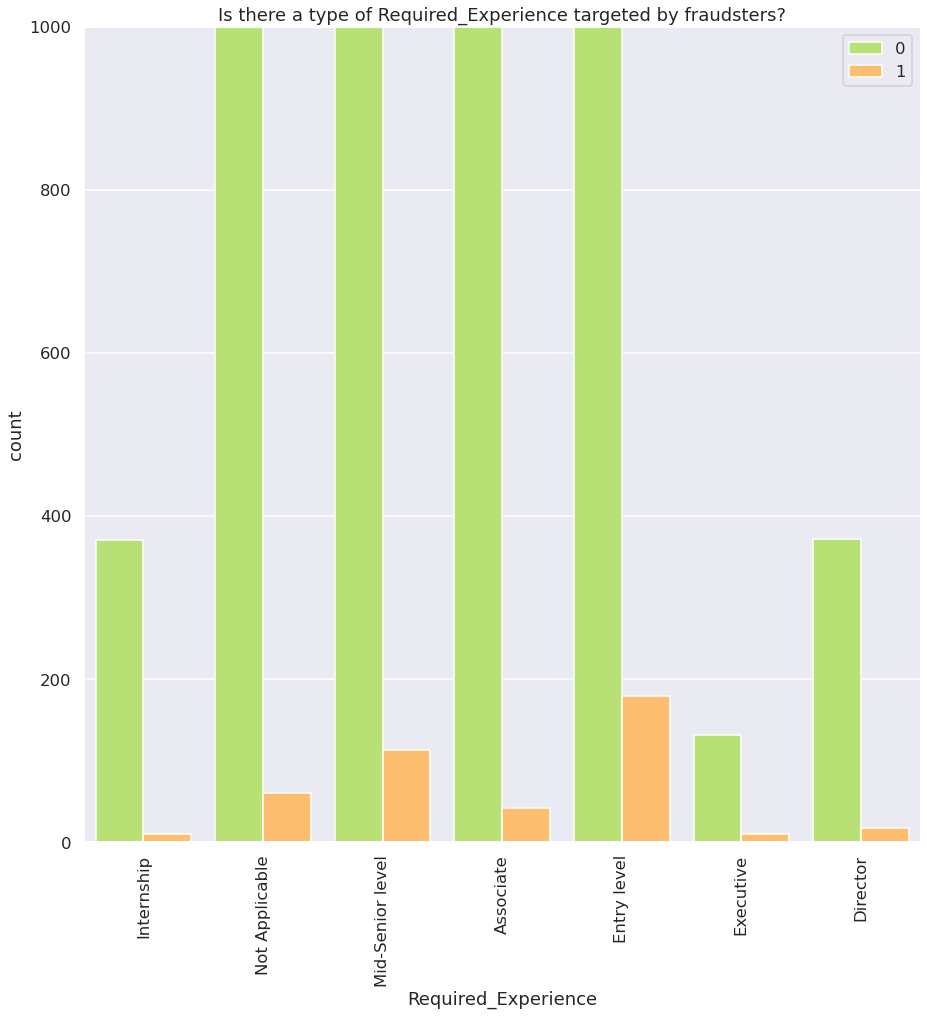

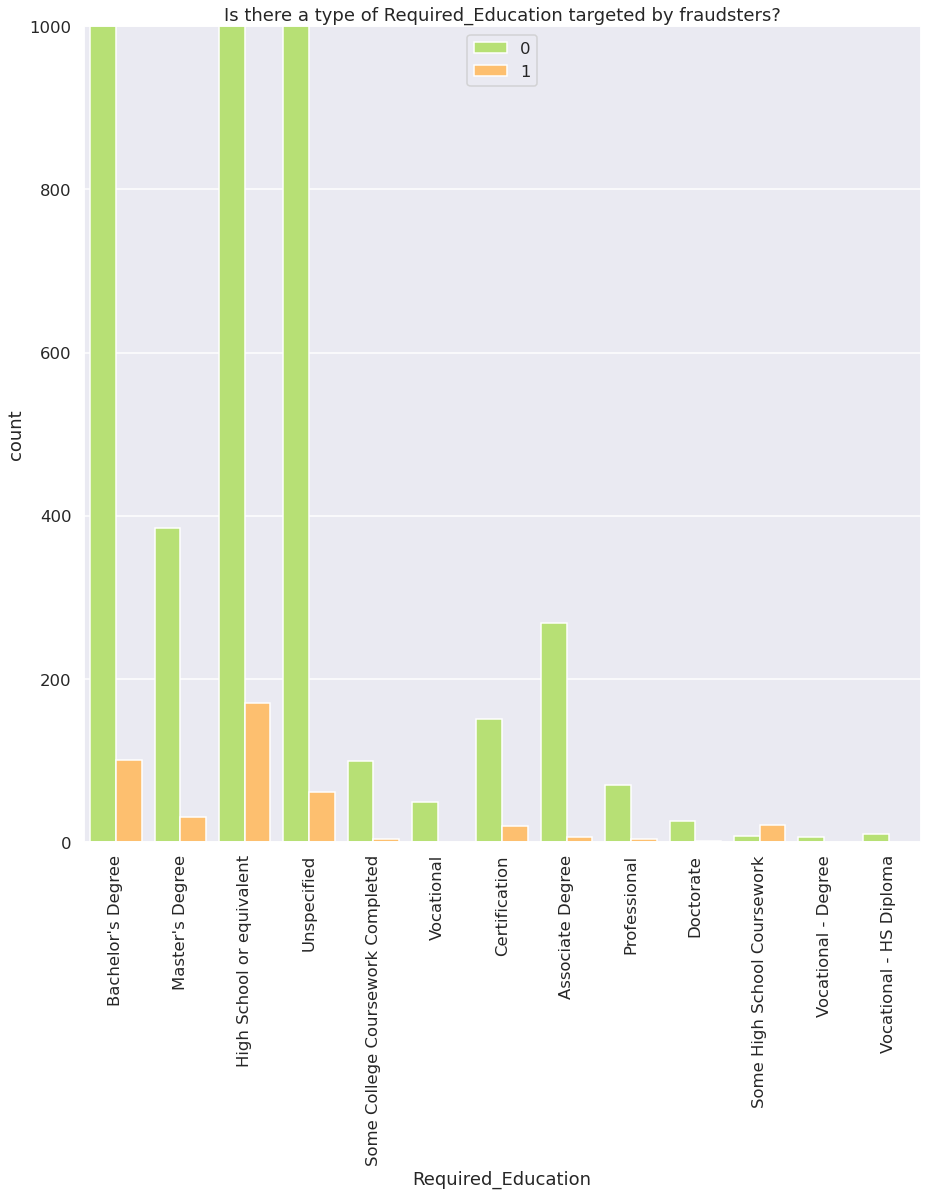

In [72]:
plots.Plots.count_plot(df,11,14)

In [73]:
vocab = {}
for i in tokens_cp:
    vocab[i] = vocab.get(i, 0) + 1

for i, t in enumerate(sorted(vocab.items(), key=lambda x:x[1], reverse=True), start=1):
    print(i, t)

1 ('work', 4264)
2 ('benefits', 3625)
3 ('company', 3246)
4 ('competitive', 2919)
5 ('team', 2645)
6 ('salary', 2430)
7 ('time', 2340)
8 ('paid', 2249)
9 ('amp', 2015)
10 ('insurance', 1944)
11 ('dental', 1908)
12 ('offer', 1852)
13 ('full', 1840)
14 ('opportunity', 1722)
15 ('working', 1674)
16 ('health', 1600)
17 ('environment', 1585)
18 ('package', 1551)
19 ('us', 1444)
20 ('job', 1416)
21 ('medical', 1382)
22 ('vacation', 1373)
23 ('life', 1372)
24 ('training', 1304)
25 ('experience', 1299)
26 ('vision', 1244)
27 ('career', 1223)
28 ('people', 1205)
29 ('hours', 1200)
30 ('based', 1166)
31 ('including', 1154)
32 ('great', 1128)
33 ('days', 1084)
34 ('part', 1083)
35 ('office', 1071)
36 ('free', 1048)
37 ('plan', 1047)
38 ('well', 1024)
39 ('pay', 1019)
40 ('new', 1018)
41 ('employees', 1015)
42 ('opportunities', 995)
43 ('employment', 994)
44 ('also', 963)
45 ('see', 961)
46 ('year', 957)
47 ('growing', 950)
48 ('compensation', 934)
49 ('business', 899)
50 ('development', 878)
51 (

1625 ('optionspremium', 32)
1626 ('amazonunlimited', 32)
1627 ('simply', 32)
1628 ('constant', 32)
1629 ('investor', 32)
1630 ('condition', 32)
1631 ('perfect', 31)
1632 ('chair', 31)
1633 ('operation', 31)
1634 ('wine', 31)
1635 ('earned', 31)
1636 ('certification', 31)
1637 ('clicking', 31)
1638 ('respectful', 31)
1639 ('ignore', 31)
1640 ('magic', 31)
1641 ('dec', 31)
1642 ('performers', 31)
1643 ('though', 31)
1644 ('reputation', 31)
1645 ('players', 31)
1646 ('scale', 31)
1647 ('strongly', 31)
1648 ('paintball', 31)
1649 ('hourslong', 31)
1650 ('bit', 31)
1651 ('reach', 31)
1652 ('transformation', 31)
1653 ('parts', 31)
1654 ('preferred', 31)
1655 ('worka', 31)
1656 ('made', 31)
1657 ('effort', 31)
1658 ('aan', 31)
1659 ('privately', 31)
1660 ('north', 31)
1661 ('equipped', 31)
1662 ('store', 31)
1663 ('airmembership', 31)
1664 ('choiceunlimited', 31)
1665 ('cardhalf', 31)
1666 ('ten', 31)
1667 ('legally', 31)
1668 ('educationcollege', 30)
1669 ('massage', 30)
1670 ('processes', 3

2778 ('write', 14)
2779 ('creates', 14)
2780 ('paramount', 14)
2781 ('workforce', 14)
2782 ('coverfree', 14)
2783 ('io', 14)
2784 ('labs', 14)
2785 ('imho', 14)
2786 ('teamcompetitive', 14)
2787 ('fringe', 14)
2788 ('salarywork', 14)
2789 ('relentless', 14)
2790 ('interactions', 14)
2791 ('opportunitywe', 14)
2792 ('interpersonal', 14)
2793 ('schedulesmost', 14)
2794 ('accommodate', 14)
2795 ('bbbe', 14)
2796 ('dcef', 14)
2797 ('umbrella', 14)
2798 ('birdback', 14)
2799 ('seconds', 13)
2800 ('dogs', 13)
2801 ('blindfolds', 13)
2802 ('swing', 13)
2803 ('sticks', 13)
2804 ('fullbonus', 13)
2805 ('goes', 13)
2806 ('encouraging', 13)
2807 ('commute', 13)
2808 ('mobility', 13)
2809 ('height', 13)
2810 ('mentorship', 13)
2811 ('hourscompetitive', 13)
2812 ('burbank', 13)
2813 ('preference', 13)
2814 ('cequens', 13)
2815 ('fulfilling', 13)
2816 ('items', 13)
2817 ('strictly', 13)
2818 ('specialty', 13)
2819 ('financialcompetitive', 13)
2820 ('corporations', 13)
2821 ('miller', 13)
2822 ('scen

4122 ('unconventional', 7)
4123 ('tinybop', 7)
4124 ('profitability', 7)
4125 ('depositon', 7)
4126 ('virteva', 7)
4127 ('peers', 7)
4128 ('mercer', 7)
4129 ('jp', 7)
4130 ('showtime', 7)
4131 ('vigor', 7)
4132 ('afce', 7)
4133 ('submissions', 7)
4134 ('strictest', 7)
4135 ('opportunites', 7)
4136 ('getfreedom', 7)
4137 ('valuesinspiration', 7)
4138 ('brazil', 7)
4139 ('hourshigh', 7)
4140 ('demands', 7)
4141 ('vendors', 7)
4142 ('reached', 7)
4143 ('honesty', 7)
4144 ('guy', 7)
4145 ('wilde', 7)
4146 ('describe', 7)
4147 ('occur', 7)
4148 ('profits', 7)
4149 ('executives', 7)
4150 ('blackjack', 7)
4151 ('estonia', 7)
4152 ('feb', 7)
4153 ('fracing', 7)
4154 ('transferlocation', 7)
4155 ('tablet', 7)
4156 ('politics', 7)
4157 ('hoursmuch', 7)
4158 ('movies', 7)
4159 ('closed', 7)
4160 ('arrange', 7)
4161 ('former', 7)
4162 ('regulations', 7)
4163 ('riga', 7)
4164 ('study', 7)
4165 ('customized', 7)
4166 ('holding', 7)
4167 ('writer', 7)
4168 ('framework', 7)
4169 ('qualities', 7)
4170 

5449 ('yearposting', 4)
5450 ('competive', 4)
5451 ('teamthe', 4)
5452 ('companydelivering', 4)
5453 ('exact', 4)
5454 ('joy', 4)
5455 ('holidayhealth', 4)
5456 ('sydney', 4)
5457 ('officer', 4)
5458 ('winsevery', 4)
5459 ('concepts', 4)
5460 ('tll', 4)
5461 ('household', 4)
5462 ('found', 4)
5463 ('political', 4)
5464 ('western', 4)
5465 ('reverse', 4)
5466 ('consultants', 4)
5467 ('became', 4)
5468 ('ensight', 4)
5469 ('applicationsapplications', 4)
5470 ('vary', 4)
5471 ('mo', 4)
5472 ('rent', 4)
5473 ('factory', 4)
5474 ('positioned', 4)
5475 ('sawawesome', 4)
5476 ('refund', 4)
5477 ('typo', 4)
5478 ('reduces', 4)
5479 ('continental', 4)
5480 ('performancebecome', 4)
5481 ('successfull', 4)
5482 ('operatesmake', 4)
5483 ('programdental', 4)
5484 ('urban', 4)
5485 ('obligatory', 4)
5486 ('benefitsin', 4)
5487 ('packagequiet', 4)
5488 ('bostonflexible', 4)
5489 ('ryanair', 4)
5490 ('safety', 4)
5491 ('thereafter', 4)
5492 ('makers', 4)
5493 ('thoughtful', 4)
5494 ('estimated', 4)
54

6950 ('anthem', 3)
6951 ('allowancefurnished', 3)
6952 ('allowanceannual', 3)
6953 ('holidaysprivate', 3)
6954 ('insuranceinitial', 3)
6955 ('timecompensation', 3)
6956 ('performancestart', 3)
6957 ('possiblejob', 3)
6958 ('techhub', 3)
6959 ('uksize', 3)
6960 ('competively', 3)
6961 ('snacksapple', 3)
6962 ('aramark', 3)
6963 ('therapy', 3)
6964 ('jpmorgan', 3)
6965 ('chase', 3)
6966 ('jpm', 3)
6967 ('esl', 3)
6968 ('fte', 3)
6969 ('ic', 3)
6970 ('safer', 3)
6971 ('iteration', 3)
6972 ('foundations', 3)
6973 ('joint', 3)
6974 ('philanthropies', 3)
6975 ('planfull', 3)
6976 ('kitchensharing', 3)
6977 ('pointers', 3)
6978 ('gratefully', 3)
6979 ('opportunitiesby', 3)
6980 ('hoursyou', 3)
6981 ('controlplease', 3)
6982 ('bestentry', 3)
6983 ('attachment', 3)
6984 ('vitaecover', 3)
6985 ('transcriptuniversity', 3)
6986 ('incomplete', 3)
6987 ('fbc', 3)
6988 ('kitchens', 3)
6989 ('sentier', 3)
6990 ('workersno', 3)
6991 ('potentialself', 3)
6992 ('atmospheresocial', 3)
6993 ('purposes', 3)

8601 ('milk', 2)
8602 ('sugar', 2)
8603 ('americas', 2)
8604 ('columbus', 2)
8605 ('wildshot', 2)
8606 ('answers', 2)
8607 ('grid', 2)
8608 ('compatible', 2)
8609 ('truckload', 2)
8610 ('intermodal', 2)
8611 ('bulk', 2)
8612 ('accelerate', 2)
8613 ('mankind', 2)
8614 ('optimising', 2)
8615 ('buys', 2)
8616 ('george', 2)
8617 ('berkoski', 2)
8618 ('jon', 2)
8619 ('dave', 2)
8620 ('washa', 2)
8621 ('bredon', 2)
8622 ('gather', 2)
8623 ('asalary', 2)
8624 ('proa', 2)
8625 ('experiencebenefitsa', 2)
8626 ('transcriptmasters', 2)
8627 ('digitale', 2)
8628 ('naast', 2)
8629 ('alles', 2)
8630 ('om', 2)
8631 ('bookings', 2)
8632 ('teacher', 2)
8633 ('opportunitys', 2)
8634 ('broader', 2)
8635 ('consisted', 2)
8636 ('benefitsopportunities', 2)
8637 ('bonusfull', 2)
8638 ('offtop', 2)
8639 ('laptoptraining', 2)
8640 ('schedulemonthly', 2)
8641 ('insurancebonusescompany', 2)
8642 ('outingskiller', 2)
8643 ('collocation', 2)
8644 ('resolves', 2)
8645 ('worksalary', 2)
8646 ('sco', 2)
8647 ('bonuse

9874 ('payptopaid', 1)
9875 ('contributionemployee', 1)
9876 ('bonustraining', 1)
9877 ('iip', 1)
9878 ('conditionscentrally', 1)
9879 ('commutebenefits', 1)
9880 ('sharingwhere', 1)
9881 ('checkout', 1)
9882 ('ndividual', 1)
9883 ('plum', 1)
9884 ('equities', 1)
9885 ('sapphire', 1)
9886 ('throughput', 1)
9887 ('tolerant', 1)
9888 ('contributor', 1)
9889 ('teamcollaborate', 1)
9890 ('functionalitiesdesign', 1)
9891 ('perspectiveinteract', 1)
9892 ('functionalitiesprovide', 1)
9893 ('anexcellent', 1)
9894 ('vacationemployee', 1)
9895 ('clientelecompetitive', 1)
9896 ('bonusespaid', 1)
9897 ('postionsflexible', 1)
9898 ('positionsexcellent', 1)
9899 ('dressbreakfast', 1)
9900 ('companybeer', 1)
9901 ('fridaygreat', 1)
9902 ('atmosphereopportunity', 1)
9903 ('tenants', 1)
9904 ('growthmoney', 1)
9905 ('ka', 1)
9906 ('hirereporting', 1)
9907 ('stuffwe', 1)
9908 ('getcompetitive', 1)
9909 ('optionsextensive', 1)
9910 ('effortsopportunity', 1)
9911 ('businesswork', 1)
9912 ('fundnation', 1)

11226 ('budge', 1)
11227 ('remunerationsubstantial', 1)
11228 ('exc', 1)
11229 ('locum', 1)
11230 ('airfares', 1)
11231 ('webyou', 1)
11232 ('barely', 1)
11233 ('messagehappy', 1)
11234 ('referenceable', 1)
11235 ('customerstransparent', 1)
11236 ('realistically', 1)
11237 ('targeted', 1)
11238 ('appreciates', 1)
11239 ('clearance', 1)
11240 ('yearand', 1)
11241 ('farmdrop', 1)
11242 ('healthcarepensioncycle', 1)
11243 ('schemefresh', 1)
11244 ('directional', 1)
11245 ('humorlocation', 1)
11246 ('teamlovely', 1)
11247 ('salaryflexibility', 1)
11248 ('environmenttravelconference', 1)
11249 ('anxiety', 1)
11250 ('athletes', 1)
11251 ('filmmakers', 1)
11252 ('healthlifedisability', 1)
11253 ('abide', 1)
11254 ('subscribe', 1)
11255 ('subset', 1)
11256 ('medicalstock', 1)
11257 ('optionsvacation', 1)
11258 ('brl', 1)
11259 ('airconditioned', 1)
11260 ('disciplineshej', 1)
11261 ('ciao', 1)
11262 ('ahoj', 1)
11263 ('goededag', 1)
11264 ('colleaguesflat', 1)
11265 ('atmospherechallenging', 1

12669 ('trainingpaid', 1)
12670 ('weeklyhigh', 1)
12671 ('residualsresidential', 1)
12672 ('accountsperformers', 1)
12673 ('quicklycurrently', 1)
12674 ('recognizes', 1)
12675 ('opportunitiesthai', 1)
12676 ('londonapple', 1)
12677 ('experienceestablished', 1)
12678 ('vacationpersonal', 1)
12679 ('programcool', 1)
12680 ('diegodiscounted', 1)
12681 ('ruled', 1)
12682 ('stuffy', 1)
12683 ('crafts', 1)
12684 ('jewellery', 1)
12685 ('herbal', 1)
12686 ('worst', 1)
12687 ('suffers', 1)
12688 ('bluesmart', 1)
12689 ('splitting', 1)
12690 ('buenos', 1)
12691 ('aires', 1)
12692 ('planthe', 1)
12693 ('weekwe', 1)
12694 ('topic', 1)
12695 ('debate', 1)
12696 ('replacement', 1)
12697 ('brainer', 1)
12698 ('programwe', 1)
12699 ('divided', 1)
12700 ('plansit', 1)
12701 ('concerns', 1)
12702 ('noteyou', 1)
12703 ('frontline', 1)
12704 ('environmentlots', 1)
12705 ('experiencesuper', 1)
12706 ('changefull', 1)
12707 ('worktreated', 1)
12708 ('collaboratorrecommendation', 1)
12709 ('letterstandard',

14069 ('contributionsperformance', 1)
14070 ('businessyou', 1)
14071 ('nopension', 1)
14072 ('yesprivate', 1)
14073 ('nolife', 1)
14074 ('fdf', 1)
14075 ('validated', 1)
14076 ('mechanics', 1)
14077 ('insuranceipad', 1)
14078 ('telephoneshort', 1)
14079 ('paymedical', 1)
14080 ('ptocompensation', 1)
14081 ('shoreditchregular', 1)
14082 ('eventsopportunity', 1)
14083 ('brandswork', 1)
14084 ('ethoswork', 1)
14085 ('engineersensure', 1)
14086 ('programptocasual', 1)
14087 ('friendlyinterested', 1)
14088 ('certainty', 1)
14089 ('conceived', 1)
14090 ('blakely', 1)
14091 ('shot', 1)
14092 ('soy', 1)
14093 ('mocha', 1)
14094 ('whip', 1)
14095 ('avid', 1)
14096 ('texter', 1)
14097 ('messages', 1)
14098 ('hate', 1)
14099 ('caught', 1)
14100 ('responds', 1)
14101 ('responsibilitiesquality', 1)
14102 ('testingmanual', 1)
14103 ('testingdevelop', 1)
14104 ('scriptsconduct', 1)
14105 ('resolutionissue', 1)
14106 ('managementreceiving', 1)
14107 ('managersreproducing', 1)
14108 ('developersmanage'

## 4. Extracting extra information

Some job offers have a phone, email and/or external URL information:

In [74]:
for column in df.columns:
    df[column].fillna('NA', inplace=True)
    
df = df.assign(HasEMAIL=0, HasPHONE=0, HasURL=0)
for column in df.columns[4:8]:
    for i in range(1,len(df[column])):
        if df[column][i].find('#URL_')!=-1:
            df['HasURL'][i] = 1
    for i in range(1,len(df[column])):
        if df[column][i].find('#PHONE_')!=-1:
            df['HasPHONE'][i] = 1
    for i in range(1,len(df[column])):
        if df[column][i].find('#EMAIL_')!=-1:
            df['HasEMAIL'][i] = 1

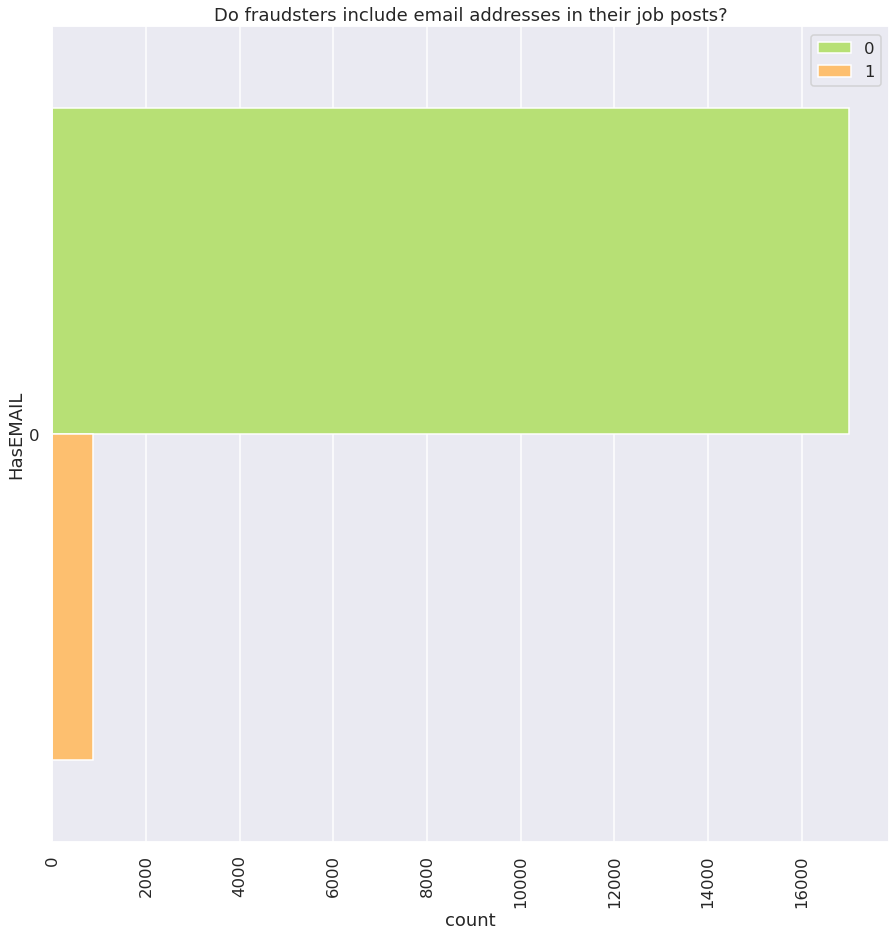

In [75]:
sns.countplot(y='HasEMAIL', hue='Fraudulent', palette='RdYlGn_r', data=df, saturation=1, orient='h')
plt.title("Do fraudsters include email addresses in their job posts?")
plt.xticks(rotation=90);
plt.legend();

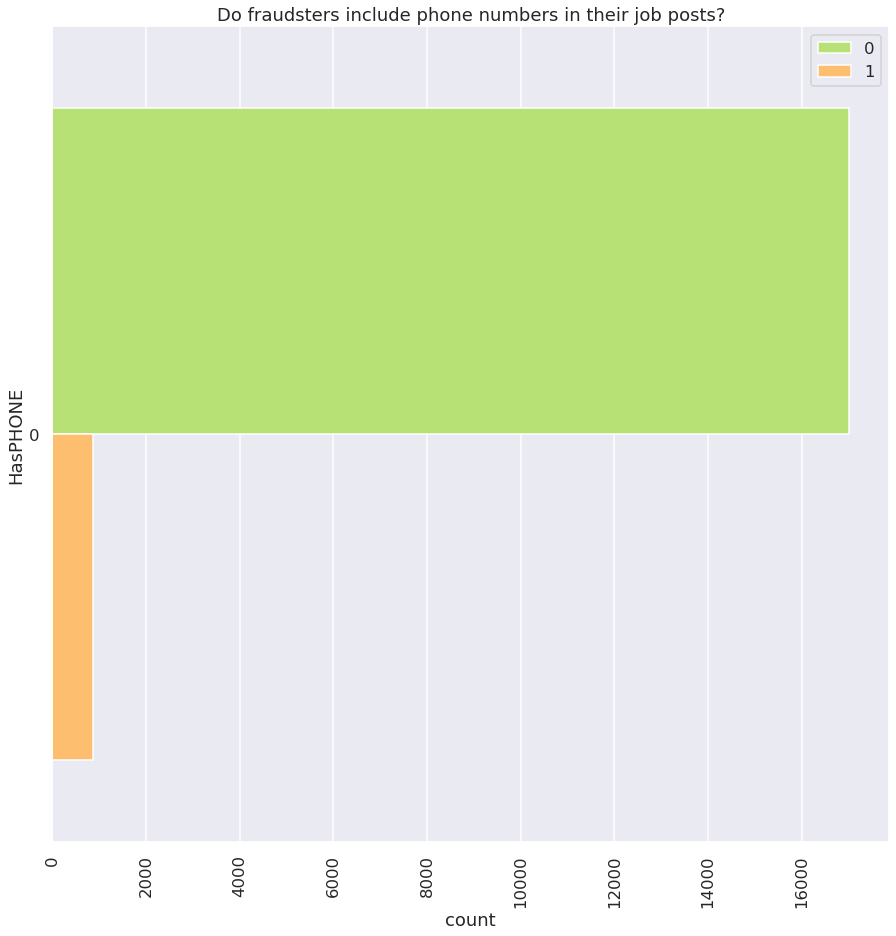

In [76]:
sns.countplot(y='HasPHONE', hue='Fraudulent', palette='RdYlGn_r', data=df, saturation=1, orient='h')
plt.title("Do fraudsters include phone numbers in their job posts?")
plt.xticks(rotation=90);
plt.legend();

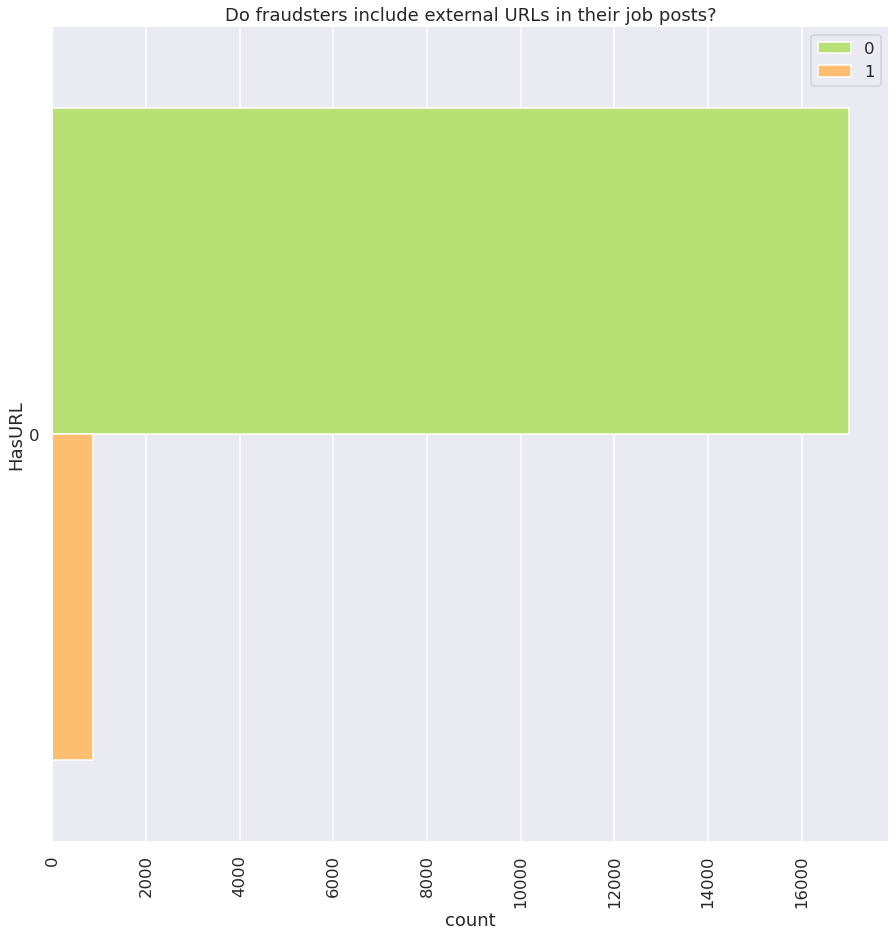

In [77]:
sns.countplot(y='HasURL', hue='Fraudulent', palette='RdYlGn_r', data=df, saturation=1, orient='h')
plt.title("Do fraudsters include external URLs in their job posts?")
plt.xticks(rotation=90);
plt.legend();

## 5. Conclusion
Unfortunately looking at the metadata is not going to be enough to identify fraudulent job posts. The fraudulent job posts follow the same pattern as legitimate job posts except:
* they tend to be lacking more information than the genuine job offers but, fraudsters will make an effort for information such as location, department, function and especially salary_range.
* when information is provided, it will tend to be shorter, the text is going to be more succinct. This characteristic is especially true for the company profile and the job requirements fields.

In terms of content, fraudulent posts will:
* target 'High school degrees or equivalent' and 'Bachelor's Degree' more than any other type of education; Doctorate, Associate Degrees and Vocational were not particularly targeted, some even not targeted at all (in this dataset at least).
* mostly advertise full-time and part-time positions. There are a few fraudulent contractor positions but, proportionally less than any other type of position and temporary contracts were not targeted at all (in this dataset at least).
* target all types of experience but mainly entry-level positions. Once again, Associates are less exposed whilst Directors, Executive and Mid-Senior levels are a little less exposed too.
* tend to refer an URL.  This URL is potentially linking to a website that will infect the victim's computer but, as phone, emails and URLs have been anonymised, it is impossible to confirm this hypothesis.
* NOT communicate a phone number. But most job ads don't anyways.

I hope this gives you a little bit more understanding of fraudulent job offers. The [following notebook](./index.ipynb) will go deeper in the analysis of this dataset and will result in the creation of a classification model helping identify the legitimacy of job posts.